# Prediction of Pre-miRNAs using deep learning models

## Config Steps

In [1]:
import os
from Bio import SeqIO
#import RNA
import numpy as np
from gensim.models import Word2Vec
import pickle
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import f1_score as f1_score_sklearn
from sklearn.metrics import confusion_matrix, classification_report
import time
import seaborn as sns
import pandas as pd
import random
from collections import Counter
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

#from keras.layers import Layer
#import keras.backend as K
#from keras.models import Sequential
#from keras.layers import LSTM, Dense, Dropout, Embedding, Flatten, Input
from itertools import product

from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt
import plotly.express as px
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Input, LSTM, Dropout, Embedding, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import epsilon
#import tensorflow as tf
#from tensorflow.keras import layers, models

2025-01-29 23:34:25.905966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738211665.917875  269189 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738211665.921427  269189 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-29 23:34:25.935542: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
path = os.getcwd()
path

'/home/jopazo/premiRNAProject/IAPUCP_Server'

## Methods

In [3]:
def get_complementary_sequence(sequences):
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
    return [''.join(complement[base] for base in seq) for seq in sequences]
def convert_RNA_sequence_to_DNA(sequence):
    return sequence.replace('U', 'T')

def convert_DNA_sequence_to_RNA(sequence):
    return sequence.replace('T', 'U')

    # Función para crear el modelo Keras
def create_model(neurons=64, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train_mirna2vec.shape[1], activation=activation))
    model.add(Dense(1, activation='sigmoid'))  # Para clasificación binaria
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Convertir las secuencias de k-mers a secuencias de índices
def sequence_to_indices(sequence, mer_to_index):
    return [mer_to_index[mer] for mer in sequence if mer in mer_to_index]

def get_vocab(comb_length=3):
    # Definir los caracteres y la longitud de las combinaciones
    chars = ['A', 'C', 'G', 'T']

    # Generar todas las combinaciones posibles de longitud n
    return [''.join(comb) for comb in product(chars, repeat=comb_length)]

def get_sequence_for_screening(mirna_gap, mirna_seqs):
    premir_positions= []
    sequence_for_screening = FastaManager.read_fasta(random.choice([
            neg_seq_chr1_1_path,
            neg_seq_chr2_1_path,
            neg_seq_chr1_2_path,
            neg_seq_chr1_3_path,
        ]))[0][:mirna_gap]
    for mirna_seq in mirna_seqs:
        initial_pos_for_neg_sample = 1000*random.randrange(5)
        neg_seq = FastaManager.read_fasta(random.choice([
            neg_seq_chr1_1_path,
            neg_seq_chr2_1_path,
            neg_seq_chr1_2_path,
            neg_seq_chr1_3_path,
        ]))[0][initial_pos_for_neg_sample:initial_pos_for_neg_sample+mirna_gap]

        premir_positions.append({
            'start': len(sequence_for_screening),
            'end': len(sequence_for_screening) + mirna_seq['length']
        })
        sequence_for_screening += mirna_seq['sequence'] + neg_seq

    return {
        'seq': sequence_for_screening,
        'pos': premir_positions
    }

def preprocess_dna_sequences(sequences, max_seq_len):
    """
    Preprocess DNA sequences into one-hot encoded matrices with padding.

    Parameters:
    - sequences (list of str): List of DNA sequences.

    Returns:
    - one_hot_matrix (np.ndarray): One-hot encoded matrix with padding.
    """
    # Define the nucleotide mapping for one-hot encoding
    nucleotide_to_index = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

    # Initialize a zero matrix for one-hot encoding
    one_hot_matrix = np.zeros((len(sequences), max_seq_len, len(nucleotide_to_index)))

    for i, seq in enumerate(sequences):
        for j, nucleotide in enumerate(seq):
            if nucleotide in nucleotide_to_index:
                # Set the corresponding position to 1
                one_hot_matrix[i, j, nucleotide_to_index[nucleotide]] = 1

    return one_hot_matrix

## Visualizer

In [4]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class Visualizer:

    @staticmethod
    def show_2d_scatter(X, y, title="PCA visualization of sequence embeddings"):
        # Apply PCA to reduce dimensionality to 2 components
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)

        # Plotting the PCA result
        plt.figure(figsize=(10, 8))
        plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
        plt.colorbar()
        plt.title(title)
        plt.xlabel("PCA component 1")
        plt.ylabel("PCA component 2")
        plt.show()

    @staticmethod
    def show_3d_scatter(X, y, title="3D PCA visualization of sequence embeddings"):
        # Apply PCA to reduce dimensionality to 2 components
        pca = PCA(n_components=3)
        X_pca = pca.fit_transform(X)

        # Plotting the PCA result in 3D
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis')
        legend1 = ax.legend(*scatter.legend_elements(), title="Classes")
        ax.add_artist(legend1)
        ax.set_title(title)
        ax.set_xlabel("PCA component 1")
        ax.set_ylabel("PCA component 2")
        ax.set_zlabel("PCA component 3")
        plt.show()

    @staticmethod
    def show_variance(X):
        pca = PCA()
        pca.fit_transform(X)
        # Explained variance
        explained_variance = pca.explained_variance_
        total_explained_variance = explained_variance.sum()

        # Print results
        print(f"Explained Variance:\n{explained_variance}")
        print(f"Total Explained Variance: {total_explained_variance:.4f}")


## Generate Dataset

### Positive Samples

In [5]:
df = pd.read_csv(f'{path}/data/dataset_DNA.csv')
df

,pos_inicial,pos_final,secuencia,chromosome,sequence_length
0,65058434,65058508,TGCCATCCTTCAGTTATCACAGTACTGTACCTTTAGAATAGACAGC...,chr1,74
1,207802443,207802523,CTCCTAAAACACTGATTTCAAATGGTGCTAGATACAAAGATGGAAA...,chr1,80
2,109598893,109598967,GGCTGTGCCGGGTAGAGAGGGCAGTGGGAGGTAAGAGCTCTTCACC...,chr1,74
3,9151668,9151777,GGGCCCCACAACGTGCAGCACTTCTAGGGCAGTATACTTGCTGATT...,chr1,109
4,198858873,198858982,AAGCGGGGCCACAGTTGCATTCATTGTTCAGTGAGCTTGTCCACAC...,chr1,109
...,...,...,...,...,...
715,79866495,79866583,CATTTCCCAATCCAGGACATAAGTGTCTTCCAAACCTCCCCCTTAT...,chr2,88
716,50696172,50696262,ATACGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTATGT...,chr2,90
717,218823090,218823154,AAAAGGGAAGATGGTGACCACATAGGAGGGACAGCGGCCTTTCCAA...,chr2,64
718,149330278,149330373,TCTCTCCAGTTCCGCTCACCCTGCGGGCGGGAGCGCGGCGCCCGGG...,chr2,95


In [6]:
df = df.loc[(df['chromosome'] == 'chr1') |  (df['chromosome'] == 'chr10') |  (df['chromosome'] == 'chr11') |  (df['chromosome'] == 'chr12') |  (df['chromosome'] == 'chr13') | (df['chromosome'] == 'chr14') | (df['chromosome'] == 'chr15') | (df['chromosome'] == 'chr2')]
df = df.loc[~df['secuencia'].str.contains('N')]
df = df.drop_duplicates(subset='secuencia')
df['secuencia'] = df['secuencia'].str.replace('\n', '')
df['secuencia'] = df['secuencia'].str.replace('\r', '')
df

,pos_inicial,pos_final,secuencia,chromosome,sequence_length
0,65058434,65058508,TGCCATCCTTCAGTTATCACAGTACTGTACCTTTAGAATAGACAGC...,chr1,74
1,207802443,207802523,CTCCTAAAACACTGATTTCAAATGGTGCTAGATACAAAGATGGAAA...,chr1,80
2,109598893,109598967,GGCTGTGCCGGGTAGAGAGGGCAGTGGGAGGTAAGAGCTCTTCACC...,chr1,74
3,9151668,9151777,GGGCCCCACAACGTGCAGCACTTCTAGGGCAGTATACTTGCTGATT...,chr1,109
4,198858873,198858982,AAGCGGGGCCACAGTTGCATTCATTGTTCAGTGAGCTTGTCCACAC...,chr1,109
...,...,...,...,...,...
715,79866495,79866583,CATTTCCCAATCCAGGACATAAGTGTCTTCCAAACCTCCCCCTTAT...,chr2,88
716,50696172,50696262,ATACGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTGTATGT...,chr2,90
717,218823090,218823154,AAAAGGGAAGATGGTGACCACATAGGAGGGACAGCGGCCTTTCCAA...,chr2,64
718,149330278,149330373,TCTCTCCAGTTCCGCTCACCCTGCGGGCGGGAGCGCGGCGCCCGGG...,chr2,95


In [7]:
positive_sequences = df['secuencia'].to_list()
positive_sequences[:2]

['TGCCATCCTTCAGTTATCACAGTACTGTACCTTTAGAATAGACAGCATCAGCACTGTGATAACTGAGCCAGGGCA',
 'CTCCTAAAACACTGATTTCAAATGGTGCTAGATACAAAGATGGAAAAATCTAAGCCACCATGTGAAACCAGCTTCCAGAAG']

<Axes: >

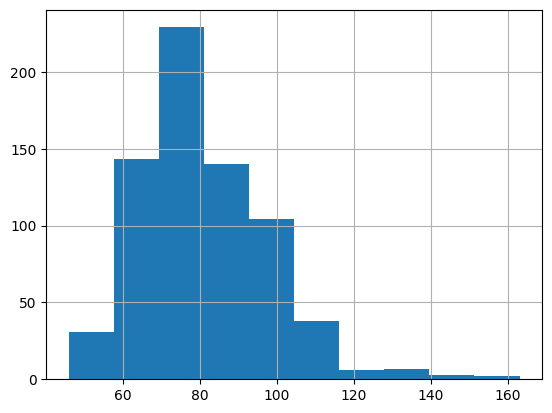

In [8]:
df['sequence_length'].hist()

<Axes: xlabel='sequence_length'>

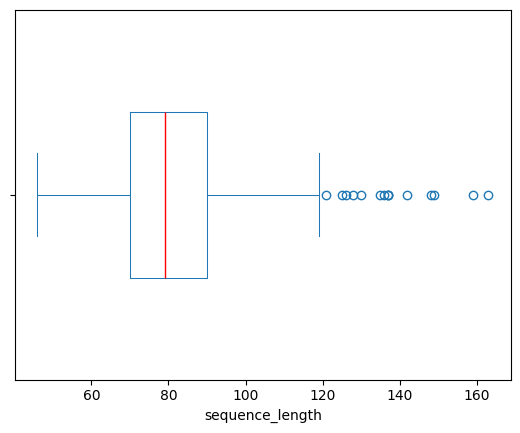

In [9]:
sns.boxplot(
    x=df["sequence_length"], 
    fill=False, 
    gap=.1, 
    width=.5, 
    linecolor="#efefef", 
    linewidth=.75, 
    medianprops={"color": "r", "linewidth": 1},
    )

In [10]:
positive_sequences.extend([s[::-1] for s in positive_sequences])
positive_sequences.extend(get_complementary_sequence(positive_sequences))

In [11]:
num_sample_for_screening = 50
sampled_sequences_for_screening = random.sample(positive_sequences, num_sample_for_screening)

# Remove the sampled sequences from the original list
for seq in sampled_sequences_for_screening:
    positive_sequences.remove(seq)

mirnas_for_screening = []
for row in sampled_sequences_for_screening:
    # Create a dictionary for each row
    dictionary = {
        'sequence': row,
        'length': len(row)
    }
    # Append the dictionary to the list
    mirnas_for_screening.append(dictionary)

mirnas_for_screening[:2]

[{'sequence': 'GACTGAAAAAACCCCTCACCTCCCCATCCCTCACTCTTTGTAACAAGTACGAGGGGTGGGAAGATGAGGGATTTTTTCAGTC',
  'length': 82},
 {'sequence': 'TTCTACACCTGGTATAATGTATGCTGTGTCTCTATCGCGTACAAGATACCAGTTGGTAGAA',
  'length': 61}]

In [12]:
len(positive_sequences)

2762

### Negative Samples

In [13]:
df_negative_sources = pd.read_csv(f'{path}/data/negative_sequences_source.csv')
df_negative_sources

,Unnamed: 0,Sequence,Chromosome,Start,End,Strand,Length
0,0,TGATTTAAGAACCGCTTATTTAAATAAGTGGTGTTCAGGGTCAGAG...,1,65068434,65079508,1,11074
1,1,TATCTAGAATGTTTGAAGGAATTATATAACAAACACAATGGATCTA...,1,210429133,210435133,1,6000
2,2,CATTTCTACTGAAAAAACAAAAATTAGCCAGGTATGGTGGCACACG...,1,210529133,210538133,1,9000
3,3,CTGGGCCAGTGCTCAGGAGGCTCCGTGCCAGCTGGAACACCGGGAA...,10,1167000,1168500,1,1500
4,4,ACACACAGTCTCTGCACGATGAGACCCTGCACCCAACACACAGTCT...,11,1167000,1169000,1,2000
5,5,TCTGTGCTTATCTGTGTCGTTTCTCATCTGTTGTTAATACGCCACA...,12,1167000,1170000,1,3000
6,6,CTGAGGAAAATCACAGGAGGCAGGAATGTATACTGTTTGTTGGGAA...,13,99653059,99663059,1,10000
7,7,CCAGCAGGCAACAGGTGGCATCACTGCTGGCAGGTTTGTCTCCTGG...,2,99653059,99673059,1,20000


In [14]:
negative_sequences_ensemble = []
#substring_length = random.choice([i for i in range(min(len(seq) for seq in positive_sequences), max(len(seq) for seq in positive_sequences))])
substring_length = 80
for negative_sequence_ensemble in df_negative_sources['Sequence']:
    substrings = []
    for idx in range(0, len(negative_sequence_ensemble)-substring_length, int(substring_length)):
        new_sequence = negative_sequence_ensemble[idx:idx+substring_length]
        substrings.append(new_sequence)
    negative_sequences_ensemble.extend(substrings)
len(negative_sequences_ensemble)

780

In [15]:
negative_sequences_ensemble.extend([s[::-1] for s in negative_sequences_ensemble])
negative_sequences_ensemble.extend(get_complementary_sequence(negative_sequences_ensemble))
random.shuffle(negative_sequences_ensemble)
negative_sequences_ensemble = negative_sequences_ensemble[:len(positive_sequences)]
len(negative_sequences_ensemble)

2762

## Modelo con Red Neuronal

In [16]:
#from keras.metrics import Precision, Recall
#from keras.backend import epsilon
#from tensorflow.keras.layers import Dropout
#from tensorflow.keras.regularizers import l2

# Instantiate Precision and Recall outside the f1_score function
precision = Precision()
recall = Recall()

# Calculate F1-score using Precision and Recall
def f1_score_custom(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + epsilon()))

def create_model(dropout=0.1, neurons=32, activation='relu', optimizer='adam', l2_val=0.001):
    model = Sequential()
    model.add(Input(shape=(128,)))  # trainable=True permite que los embeddings se actualicen
    model.add(Dense(neurons, activation=activation, kernel_regularizer=l2(l2_val)))  # L2 regularization , kernel_regularizer=l2(0.001)
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    #model.add(Dense(neurons // 4, activation=activation, kernel_regularizer=l2(l2_val)))  # L2 regularization , kernel_regularizer=l2(0.001)
    #model.add(BatchNormalization())
    #model.add(Dropout(dropout))
    #model.add(Dense(neurons // 4, activation=activation, kernel_regularizer=l2(l2_val)))  # L2 regularization , kernel_regularizer=l2(0.001)
    #model.add(BatchNormalization())
    model.add(Dense(neurons // 8, activation=activation, kernel_regularizer=l2(l2_val)))  # L2 regularization , kernel_regularizer=l2(0.001)
    model.add(BatchNormalization())
    model.add(Dropout(dropout))  # dropout rate
    model.add(Dense(1, activation='sigmoid'))  # Capa de salida para clasificación binaria
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', f1_score_custom])
    return model

W0000 00:00:1738211667.294097  269189 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Modelo con Mecanismo de Atención

In [17]:
def create_model_LSTM(mer_to_index, miRNA2Vec, max_seq_len, lstm=32, dropout=0.1, neurons=32, activation='relu', optimizer='adam', l2_val=0.001):
    # Create the embedding matrix using pre-trained Word2Vec weights
    embedding_matrix = np.zeros((len(mer_to_index) + 1, miRNA2Vec.model.vector_size))

    for mer, i in mer_to_index.items():
        embedding_matrix[i] = miRNA2Vec.model.wv[mer]

    model = Sequential()
    # Add the Embedding layer with pre-trained Word2Vec weights
    model.add(Embedding(input_dim=len(mer_to_index) + 1,
                        output_dim=miRNA2Vec.model.vector_size,
                        weights=[embedding_matrix],
                        input_length=max_seq_len,
                        trainable=True))  # Allow fine-tuning of embeddings

    # Add the LSTM layer
    model.add(LSTM(units=lstm, return_sequences=False, dropout=0.3, recurrent_dropout=0.3))  # `return_sequences=False` for one output per sequence

    # Add fully connected layers
    model.add(Dense(neurons, activation=activation, kernel_regularizer=l2(l2_val)))  # Fully connected layer with L2 regularization
    model.add(Dense(neurons // 2, activation=activation, kernel_regularizer=l2(l2_val)))  # Fully connected layer with L2 regularization
    model.add(Dropout(dropout))  # Dropout after the dense layer

    # Add output layer
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])  # Use appropriate metrics

    return model

## MiRNA2Vec

In [46]:
class MiRNA2Vec:
    def __init__(self, k_mers: int = 3, vector_size: int = 100, epochs: int = 5, skip_gram = 1, min_count = 1, hs = 1, alpha = 0.01, min_alpha=0.01):
        self.__model = None
        self.k_mers = k_mers
        self.vector_size = vector_size
        self.epochs = epochs
        self.window = 5
        self.min_count = min_count
        self.workers = 8
        self.skip_gram = skip_gram
        self.hs = hs
        self.alpha = alpha
        self.min_alpha = min_alpha

    @property
    def model(self):
        return self.__model

    def __get_tokens(self, sequence):
        return [sequence[i:i + self.k_mers] for i in range(len(sequence) - self.k_mers + 1)]

    def tokenize_sequences(self, sequences):
        """Tokenize sequences into k-mers."""
        tokenized_sequences = []
        for seq in sequences:
            tokens = self.__get_tokens(seq)
            tokenized_sequences.append(tokens)
        return tokenized_sequences

    def train_word2vec(self, tokenized_sequences):
        """Train Word2Vec model on tokenized sequences."""
        self.__model = Word2Vec(sentences=tokenized_sequences,
                                vector_size=self.vector_size,
                                window=self.window,
                                min_count=self.min_count,
                                workers=self.workers,
                                epochs=self.epochs,
                                sg=self.skip_gram,
                                hs=self.hs,
                                alpha=self.alpha,
                                min_alpha=self.min_alpha)
        return self.__model

    def get_average_embeddings(self, sequences):
        """Get average embedding for each sequence."""
        embeddings = []
        for seq in sequences:
            tokens = self.__get_tokens(seq)
            token_embeddings = [self.model.wv[token] for token in tokens if token in self.model.wv]
            if token_embeddings:
                avg_embedding = np.mean(token_embeddings, axis=0)
            else:
                avg_embedding = np.zeros(self.model.vector_size)
            embeddings.append(avg_embedding.tolist())
        return np.array(embeddings)

    def get_median_embeddings(self, sequences):
        """Get median embedding for each sequence."""
        embeddings = []
        for seq in sequences:
            tokens = self.__get_tokens(seq)
            token_embeddings = [self.model.wv[token] for token in tokens if token in self.model.wv]
            if token_embeddings:
                median_embedding = np.median(token_embeddings, axis=0)
            else:
                median_embedding = np.zeros(self.model.vector_size)
            embeddings.append(median_embedding.tolist())
        return np.array(embeddings)


    def load_model(self, path, tokenized_sequences):
        self.__model = Word2Vec(sentences=tokenized_sequences,
                                vector_size=self.vector_size,
                                window=self.window,
                                min_count=self.min_count,
                                workers=self.workers,
                                epochs=self.epochs)
        self.__model.wv = KeyedVectors.load_word2vec_format(path,
                                          binary=False)  # Change binary to False if the model is in text format
        # Continue training the Word2Vec model with your new sequences
        self.__model.build_vocab(tokenized_sequences, update=True)  # Update the vocabulary with new sentences
        self.__model.train(tokenized_sequences, total_examples=self.__model.corpus_count, epochs=self.__model.epochs)
        return self.__model


In [19]:
y_positive = np.ones(len(positive_sequences))
y_negative = np.zeros(len(negative_sequences_ensemble))

X = positive_sequences + negative_sequences_ensemble
y = np.append(y_positive, y_negative)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=48)

In [65]:
# Create miRNA2Vec instance
miRNA2Vec = MiRNA2Vec(
    k_mers=5, 
    vector_size=128, 
    epochs=100,
    skip_gram=0,
    min_count=1,
    hs=1,
    alpha=0.1,
    min_alpha=0.01
)
# Create the dataset for Word2Vec
tokenized_sequences = miRNA2Vec.tokenize_sequences(X_train)
# Train the Word2Vec model
miRNA2Vec.train_word2vec(tokenized_sequences)

# Crear un diccionario para mapear cada k-mer a un índice
mer_to_index = {mer: i+1 for i, mer in enumerate(miRNA2Vec.model.wv.index_to_key)}
index_to_mer = {i+1: mer for i, mer in enumerate(miRNA2Vec.model.wv.index_to_key)}



In [21]:
vocab = get_vocab(miRNA2Vec.k_mers)
word_vec_dict={}
for word in vocab:
  word_vec_dict[word]=miRNA2Vec.model.wv.get_vector(word)
len(vocab)

1024

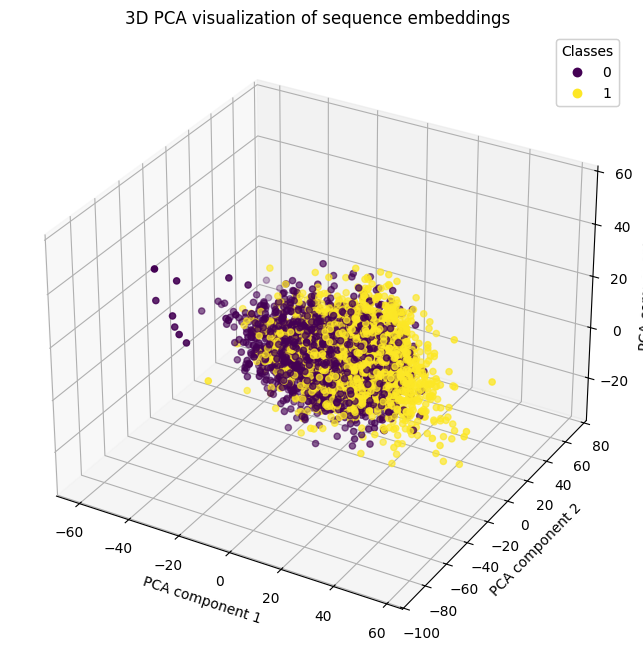

In [67]:
Visualizer.show_3d_scatter(miRNA2Vec.get_median_embeddings(X_train),y_train)

In [70]:
def get_centroid_distance():
    positive_vectors = []
    negative_vectors = []
    for i in range(len(X_train)):
        if (y_train[i] == 1):
            positive_vectors.append(miRNA2Vec.get_median_embeddings([X_train[i]])[0])
        else:
            negative_vectors.append(miRNA2Vec.get_median_embeddings([X_train[i]])[0])
    positive_vectors = np.array(positive_vectors)
    negative_vectors = np.array(negative_vectors)
    # Compute centroids
    centroid_pos = np.mean(positive_vectors, axis=0)
    centroid_neg = np.mean(negative_vectors, axis=0)

    # Compute Euclidean distance
    distance_centroids = np.linalg.norm(centroid_pos - centroid_neg)
    print(f"Centroid Distance: {distance_centroids:.4f}")
    return distance_centroids

def get_variance_ratio():
    positive_vectors = []
    negative_vectors = []
    for i in range(len(X_train)):
        if (y_train[i] == 1):
            positive_vectors.append(miRNA2Vec.get_median_embeddings([X_train[i]])[0])
        else:
            negative_vectors.append(miRNA2Vec.get_median_embeddings([X_train[i]])[0])
    positive_vectors = np.array(positive_vectors)
    negative_vectors = np.array(negative_vectors)
    # Compute intra-class variance
    var_pos = np.var(positive_vectors, axis=0).mean()
    var_neg = np.var(negative_vectors, axis=0).mean()
    intra_class_variance = (var_pos + var_neg) / 2

    # Compute centroids
    centroid_pos = np.mean(positive_vectors, axis=0)
    centroid_neg = np.mean(negative_vectors, axis=0)
    # Compute inter-class variance
    inter_class_variance = np.var([centroid_pos, centroid_neg], axis=0).mean()

    # Variance ratio
    variance_ratio = inter_class_variance / intra_class_variance
    print(f"Variance Ratio: {variance_ratio:.4f}")

get_centroid_distance()
get_variance_ratio()

Centroid Distance: 11.6869
Variance Ratio: 0.0156


In [23]:
indexed_sequences_train = [sequence_to_indices(seq, mer_to_index) for seq in tokenized_sequences]

In [24]:
tokenized_sequences_test = miRNA2Vec.tokenize_sequences(X_test)

indexed_sequences_test = [sequence_to_indices(seq, mer_to_index) for seq in tokenized_sequences_test]

# Padding para asegurar que todas las secuencias tengan la misma longitud
max_seq_len_test = max(len(seq) for seq in indexed_sequences_test)

In [25]:
tokenized_sequences_val = miRNA2Vec.tokenize_sequences(X_val)

indexed_sequences_val = [sequence_to_indices(seq, mer_to_index) for seq in tokenized_sequences_val]

# Padding para asegurar que todas las secuencias tengan la misma longitud
max_seq_len_val = max(len(seq) for seq in indexed_sequences_val)

In [26]:
# Padding para asegurar que todas las secuencias tengan la misma longitud
max_seq_len_train = max(len(seq) for seq in indexed_sequences_train)
max_seq_len = max(max_seq_len_train, max_seq_len_test, max_seq_len_val)
X_train_pad_sequences = pad_sequences(indexed_sequences_train, maxlen=max_seq_len, padding='post')
X_test_pad_sequences = pad_sequences(indexed_sequences_test, maxlen=max_seq_len, padding='post')
X_val_pad_sequences = pad_sequences(indexed_sequences_val, maxlen=max_seq_len, padding='post')

X_train_pad_sequences.shape

(3866, 160)

In [27]:
X_val_pad_sequences.shape

(829, 160)

In [28]:
X_train_pad_sequences.shape

(3866, 160)

In [29]:
# Get embeddings for sequences
X_train_mirna2vec = miRNA2Vec.get_median_embeddings(X_train)
X_test_mirna2vec = miRNA2Vec.get_median_embeddings(X_test)
X_val_mirna2vec = miRNA2Vec.get_median_embeddings(X_val)
model_nn = create_model(dropout=0.7, neurons=64, activation='relu', optimizer='adam', l2_val=0.01)

model_nn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8)              │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,073 (35.44 KB)

 Trainable params: 8,929 (34.88 KB)

 Non-trainable params: 144 (576.00 B)

In [31]:
"""
from tensorflow.keras.models import Model
inputs = Input(shape=(128,), name="input_layer")
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.7)(x)
x = Dense(64 // 8, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.7)(x)
outputs = Dense(1, activation='sigmoid', name="output_layer")(x)

modelsummary = Model(inputs=inputs, outputs=outputs)
modelsummary.summary()
"""

'\nfrom tensorflow.keras.models import Model\ninputs = Input(shape=(128,), name="input_layer")\nx = Dense(64, activation=\'relu\', kernel_regularizer=l2(0.01))(inputs)\nx = BatchNormalization()(x)\nx = Dropout(0.7)(x)\nx = Dense(64 // 8, activation=\'relu\', kernel_regularizer=l2(0.01))(x)\nx = BatchNormalization()(x)\nx = Dropout(0.7)(x)\noutputs = Dense(1, activation=\'sigmoid\', name="output_layer")(x)\n\nmodelsummary = Model(inputs=inputs, outputs=outputs)\nmodelsummary.summary()\n'

In [32]:
# Entrenar el modelo
history_model_nn = model_nn.fit(X_train_mirna2vec, y_train, epochs=800, verbose=1, validation_data=(X_val_mirna2vec, y_val), batch_size = 2048)

Epoch 1/800


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - accuracy: 0.5260 - f1_score_custom: 0.5219 - loss: 1.9208 - val_accuracy: 0.5271 - val_f1_score_custom: 0.4957 - val_loss: 1.6805
Epoch 2/800
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5036 - f1_score_custom: 0.5017 - loss: 1.8929 - val_accuracy: 0.5428 - val_f1_score_custom: 0.4929 - val_loss: 1.6635
Epoch 3/800
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5298 - f1_score_custom: 0.5025 - loss: 1.8432 - val_accuracy: 0.5645 - val_f1_score_custom: 0.5001 - val_loss: 1.6465
Epoch 4/800
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5449 - f1_score_custom: 0.5084 - loss: 1.7941 - val_accuracy: 0.5766 - val_f1_score_custom: 0.5087 - val_loss: 1.6294
Epoch 5/800
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5511 - f1_score_custom: 0.5164 - loss: 1.7478 - val_accuracy: 0.5814 - val_f1_score_custom: 0.5159 - val_loss: 1.6122
Epoch 6/800
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5425 - f1_score_custom: 0.5190 - loss

Text(0.5, 1.0, 'Loss Curve')

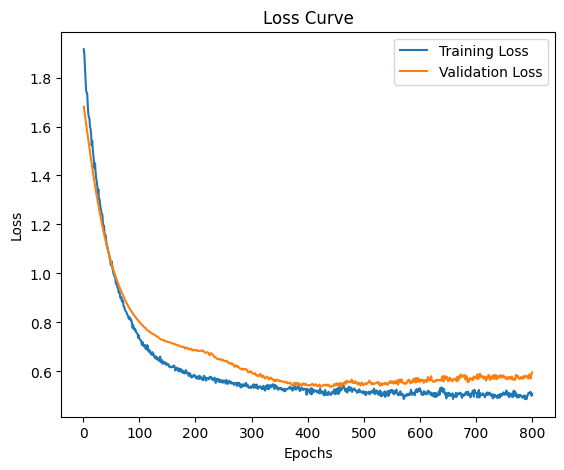

In [33]:
loss = history_model_nn.history['loss']
val_loss = history_model_nn.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(14, 5))

# Gráfico de loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

Text(0.5, 1.0, 'Accuracy Curve')

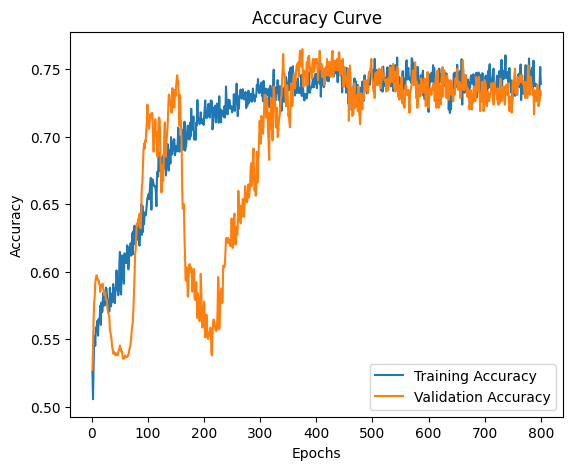

In [34]:
loss = history_model_nn.history['accuracy']
val_loss = history_model_nn.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(14, 5))

# Gráfico de loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Accuracy')
plt.plot(epochs, val_loss, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

In [35]:
y_pred = (np.array([ele[0] for ele in model_nn.predict(X_test_mirna2vec)]) > 0.5).astype("int32")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

 1/26 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Confusion Matrix:
[[275 131]
 [ 89 334]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.68      0.71       406
         1.0       0.72      0.79      0.75       423

    accuracy                           0.73       829
   macro avg       0.74      0.73      0.73       829
weighted avg       0.74      0.73      0.73       829



In [36]:
model_LSTM = create_model_LSTM(mer_to_index, miRNA2Vec, max_seq_len, lstm=64, dropout=0.7, neurons=32, activation='relu', optimizer='adam', l2_val=0.01)
model_LSTM.summary()

/home/jopazo/miniconda3/envs/test/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,200 (512.50 KB)

 Trainable params: 131,200 (512.50 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
"""
lstm=64
dropout=0.7
neurons=32
activation='relu'
optimizer='adam'
l2_val=0.01
embedding_matrix = np.zeros((len(mer_to_index) + 1, miRNA2Vec.model.vector_size))

for mer, i in mer_to_index.items():
    embedding_matrix[i] = miRNA2Vec.model.wv[mer]

modelsummary = Sequential()
# Add the Embedding layer with pre-trained Word2Vec weights
modelsummary.add(Embedding(input_dim=len(mer_to_index) + 1,
                    output_dim=miRNA2Vec.model.vector_size,
                    weights=[embedding_matrix],
                    input_length=max_seq_len,
                    trainable=True))  # Allow fine-tuning of embeddings

# Add the LSTM layer
modelsummary.add(LSTM(units=lstm, return_sequences=False, dropout=0.3, recurrent_dropout=0.3))  # `return_sequences=False` for one output per sequence

# Add fully connected layers
modelsummary.add(Dense(neurons, activation=activation, kernel_regularizer=l2(l2_val)))  # Fully connected layer with L2 regularization
modelsummary.add(Dense(neurons // 2, activation=activation, kernel_regularizer=l2(l2_val)))  # Fully connected layer with L2 regularization
modelsummary.add(Dropout(dropout))  # Dropout after the dense layer

# Add output layer
modelsummary.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

# Compile the model
modelsummary.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])  # Use appropriate metrics

# Manually build the model by specifying input shape
modelsummary.build(input_shape=(None, max_seq_len))  # Batch size is None, sequence length is max_seq_len

# Now, call summary
modelsummary.summary()
"""

"\nlstm=64\ndropout=0.7\nneurons=32\nactivation='relu'\noptimizer='adam'\nl2_val=0.01\nembedding_matrix = np.zeros((len(mer_to_index) + 1, miRNA2Vec.model.vector_size))\n\nfor mer, i in mer_to_index.items():\n    embedding_matrix[i] = miRNA2Vec.model.wv[mer]\n\nmodelsummary = Sequential()\n# Add the Embedding layer with pre-trained Word2Vec weights\nmodelsummary.add(Embedding(input_dim=len(mer_to_index) + 1,\n                    output_dim=miRNA2Vec.model.vector_size,\n                    weights=[embedding_matrix],\n                    input_length=max_seq_len,\n                    trainable=True))  # Allow fine-tuning of embeddings\n\n# Add the LSTM layer\nmodelsummary.add(LSTM(units=lstm, return_sequences=False, dropout=0.3, recurrent_dropout=0.3))  # `return_sequences=False` for one output per sequence\n\n# Add fully connected layers\nmodelsummary.add(Dense(neurons, activation=activation, kernel_regularizer=l2(l2_val)))  # Fully connected layer with L2 regularization\nmodelsummary.

In [54]:
# Entrenar el modelo
history_LSTM = model_LSTM.fit(X_train_pad_sequences, y_train, epochs=300, verbose=1, validation_data=(X_val_pad_sequences, y_val), batch_size = 2048)

Epoch 1/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 900ms/step - accuracy: 0.4913 - loss: 1.3321 - val_accuracy: 0.4934 - val_loss: 1.3209
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step - accuracy: 0.5102 - loss: 1.3187 - val_accuracy: 0.4934 - val_loss: 1.3075
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 570ms/step - accuracy: 0.4992 - loss: 1.3059 - val_accuracy: 0.4934 - val_loss: 1.2938
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step - accuracy: 0.5082 - loss: 1.2916 - val_accuracy: 0.5054 - val_loss: 1.2805
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step - accuracy: 0.5003 - loss: 1.2788 - val_accuracy: 0.5066 - val_loss: 1.2676
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step - accuracy: 0.4962 - loss: 1.2657 - val_accuracy: 0.5066 - val_loss: 1.2549
Epoch 7/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step - accuracy: 0.4986 - loss: 1.2535 - val_accuracy: 0.5066 - val_loss: 1.2425
Epoch 8/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step - accuracy: 0.4980 - loss: 1.2408 - val_accuracy: 0.5066 - v

Text(0.5, 1.0, 'Loss Curve')

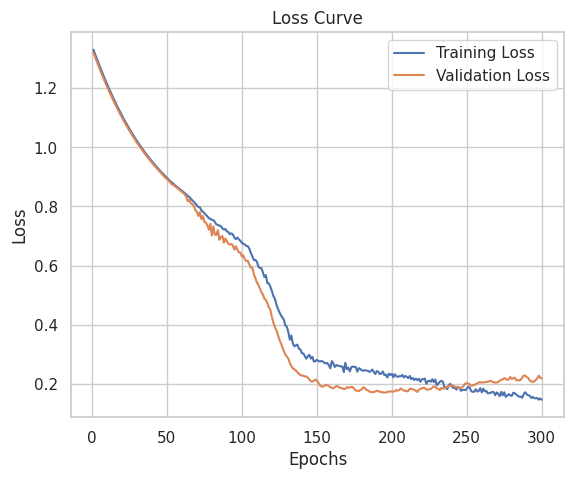

In [55]:
loss = history_LSTM.history['loss']
val_loss = history_LSTM.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(14, 5))

# Gráfico de loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

Text(0.5, 1.0, 'Accuracy Curve')

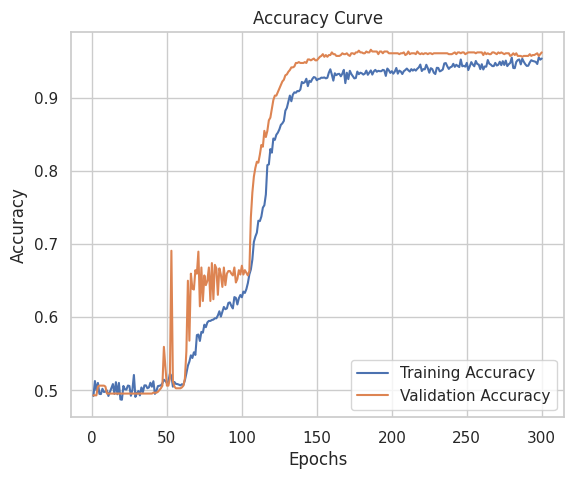

In [56]:
loss = history_LSTM.history['accuracy']
val_loss = history_LSTM.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(14, 5))

# Gráfico de loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Accuracy')
plt.plot(epochs, val_loss, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

In [57]:
y_pred = (np.array([ele[0] for ele in model_LSTM.predict(X_test_pad_sequences)]) > 0.5).astype("int32")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Confusion Matrix:
[[401   5]
 [ 21 402]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       406
         1.0       0.99      0.95      0.97       423

    accuracy                           0.97       829
   macro avg       0.97      0.97      0.97       829
weighted avg       0.97      0.97      0.97       829



## SVC


In [58]:
# Get embeddings for sequences
X_train_mirna2vec = miRNA2Vec.get_median_embeddings(X_train)
X_test_mirna2vec = miRNA2Vec.get_median_embeddings(X_test)
# Train SVM
svm_model = SVC(kernel='poly', class_weight='balanced', C=5, probability=True)
svm_model.fit(X_train_mirna2vec, y_train)
# Predict and evaluate0
y_pred = svm_model.predict(X_test_mirna2vec)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score_sklearn(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1: {f1 * 100:.2f}%")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 75.39%
Precision: 74.61%
Recall: 78.49%
F1: 76.50%
Confusion Matrix:
[[293 113]
 [ 91 332]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.76      0.72      0.74       406
         1.0       0.75      0.78      0.76       423

    accuracy                           0.75       829
   macro avg       0.75      0.75      0.75       829
weighted avg       0.75      0.75      0.75       829



## RF

In [59]:
# Get embeddings for sequences
X_train_mirna2vec = miRNA2Vec.get_median_embeddings(X_train)
X_test_mirna2vec = miRNA2Vec.get_median_embeddings(X_test)
# Train RF
rf_model = RandomForestClassifier(
        n_estimators=50,
        max_depth=10,
        min_samples_split=2,
        class_weight=None,
        max_features='sqrt',
        random_state=42
    )
rf_model.fit(X_train_mirna2vec, y_train)
# Predict and evaluate
y_pred = rf_model.predict(X_test_mirna2vec)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score_sklearn(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1: {f1 * 100:.2f}%")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 70.69%
Precision: 71.03%
Recall: 71.87%
F1: 71.45%
Confusion Matrix:
[[282 124]
 [119 304]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.69      0.70       406
         1.0       0.71      0.72      0.71       423

    accuracy                           0.71       829
   macro avg       0.71      0.71      0.71       829
weighted avg       0.71      0.71      0.71       829



# Screening

In [82]:
class Screening:

    def __init__(self, positive_sequences=[], negative_sequences=[], mirna_gap = 500, screen_size = 85):
        self.df = None
        self.list_of_positions_of_positive_samples = []
        self.mirna_gap = mirna_gap
        self.positive_sequences = positive_sequences
        self.negative_sequences = negative_sequences
        self.positive_map = {0: []}
        self.negative_map = {}
        self.positive_seq_positions = []
        self.results = []
        self.runtime = None
        self.screen_size = screen_size
        self.sequence_for_screening = ''
        for seq in positive_sequences:
            if self.positive_map.get(len(seq)):
                self.positive_map[len(seq)].append(seq)
            else:
                self.positive_map[len(seq)] = []
                self.positive_map[len(seq)].append(seq)
        for seq in negative_sequences:
            if self.negative_map.get(len(seq)):
                self.negative_map[len(seq)].append(seq)
            else:
                self.negative_map[len(seq)] = []
                self.negative_map[len(seq)].append(seq)
        self.nt_with_most_data = 0
        for nt in self.positive_map.keys():
            if len(self.positive_map[nt]) > len(self.positive_map[self.nt_with_most_data]):
                self.nt_with_most_data = nt

    def calculate_recall(self, probabilities, threshold=0.5):
        """
        Calculate Recall based on detected and expected peaks.

        Parameters:
            probabilities (list or np.ndarray): Probabilities for each position.
            threshold (float): Threshold for detecting positive samples from probabilities.

        Returns:
            float: Recall metric.
        """
        detected_indices = np.where(np.array(probabilities) > threshold)[0]

        # Group detected indices into contiguous regions (detected peaks)
        detected_peaks = []
        if len(detected_indices) > 0:
            current_peak = [detected_indices[0], detected_indices[0]]
            for idx in detected_indices[1:]:
                if idx == current_peak[1] + 1:
                    current_peak[1] = idx
                else:
                    detected_peaks.append({'start': current_peak[0], 'end': current_peak[1]})
                    current_peak = [idx, idx]
            detected_peaks.append({'start': current_peak[0], 'end': current_peak[1]})

        true_positives = 0
        false_negatives = 0

        used_ground_truth = set()

        for detected in detected_peaks:
            for i, expected in enumerate(self.positive_seq_positions):
                if i not in used_ground_truth:
                    if not (detected['end'] < expected['start'] or detected['start'] > expected['end']):
                        true_positives += 1
                        used_ground_truth.add(i)
                        break

        false_negatives = len(self.positive_seq_positions) - len(used_ground_truth)

        recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0.0
        return recall

    def calculate_iou(self, probabilities, threshold=0.5):
        """
        Calculate Intersection over Union (IoU) based on probabilities and ground truth regions.

        Parameters:
            probabilities (list or np.ndarray): Probabilities for each position.
            threshold (float): Threshold for detecting positive samples from probabilities.

        Returns:
            float: IoU metric.
        """
        detected = np.where(np.array(probabilities) > threshold, 1, 0)

        detected_set = set(np.where(detected == 1)[0])  # Indices of detected positives
        ground_truth_set = set()
        for region in self.positive_seq_positions:
            ground_truth_set.update(range(region['start'], region['end']))

        intersection = detected_set & ground_truth_set
        union = detected_set | ground_truth_set
        iou = len(intersection) / len(union) if union else 0.0

        return iou

    def calculate_precision(self, probabilities, threshold=0.5):
        """
        Calculate Precision based on detected and expected peaks.

        Parameters:
            probabilities (list or np.ndarray): Probabilities for each position.
            threshold (float): Threshold for detecting positive samples from probabilities.

        Returns:
            float: Precision metric.
        """
        detected_indices = np.where(np.array(probabilities) > threshold)[0]

        # Group detected indices into contiguous regions (detected peaks)
        detected_peaks = []
        if len(detected_indices) > 0:
            current_peak = [detected_indices[0], detected_indices[0]]
            for idx in detected_indices[1:]:
                if idx == current_peak[1] + 1:
                    current_peak[1] = idx
                else:
                    detected_peaks.append({'start': current_peak[0], 'end': current_peak[1]})
                    current_peak = [idx, idx]
            detected_peaks.append({'start': current_peak[0], 'end': current_peak[1]})

        true_positives = 0
        false_positives = 0

        for detected in detected_peaks:
            intersected = False
            for expected in self.positive_seq_positions:
                if not (detected['end'] < expected['start'] or detected['start'] > expected['end']):
                    intersected = True
                    true_positives += 1
                    break
            if not intersected:
                false_positives += 1

        precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0.0
        return precision

    def generate_sequence_for_screening(self):
        premir_positions= []
        sequence_for_screening = random.choice(df_negative_sources["Sequence"])[:self.mirna_gap]
        for mirna_seq in self.positive_sequences:
            initial_pos_for_neg_sample = 100*random.randrange(5)
            neg_seq = random.choice(df_negative_sources["Sequence"])[initial_pos_for_neg_sample:initial_pos_for_neg_sample+self.mirna_gap]
            premir_positions.append({
                'start': len(sequence_for_screening),
                'end': len(sequence_for_screening) + mirna_seq['length']
            })
            sequence_for_screening += mirna_seq['sequence'] + neg_seq

        self.sequence_for_screening = sequence_for_screening
        self.positive_seq_positions = premir_positions

    def get_results_with_word2vec_nn_and_batches(self, word2vec, model, smooth_size=200, smooth_type="mean", batch_size=512):
        self.results = []
        start = time.time()

        # Precompute tokenized and indexed sequences
        print("Generating sequences for screening...")
        all_sequences = [
            self.sequence_for_screening[idx:idx + self.screen_size]
            for idx in range(0, len(self.sequence_for_screening) - self.screen_size)
        ]
        print(f"Calculating embeddings for {len(all_sequences)} sequences...")
        embeddings = word2vec.get_median_embeddings(all_sequences)
        predictions = model.predict(embeddings)
        self.results.extend(predictions[:, 0].tolist())

        # Crear un DataFrame a partir de los datos
        self.df = pd.DataFrame({'x': range(len(self.results)), 'y': self.results})

        if (smooth_type == "mean"):
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = self.df['y'].rolling(window=smooth_size, center=True).mean()
        elif (smooth_type == "median"):
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = self.df['y'].rolling(window=smooth_size, center=True).median()
        elif (smooth_type == "mad"):
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = self.df['y'].rolling(window=smooth_size, center=True).apply(mad, raw=True)
        elif smooth_type == "gaussian":
            sigma = smooth_size / 2
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = gaussian_filter1d(self.df['y'], sigma=sigma)
        elif smooth_type == "ema":
            alpha = 2 / (smooth_size + 1)  # Smoothing factor
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = self.df['y'].ewm(span=smooth_size, adjust=False).mean()
        elif smooth_type == "savgol":
            polyorder = 2  # Degree of the polynomial
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = savgol_filter(self.df['y'], window_length=smooth_size, polyorder=polyorder, mode='nearest')
        elif smooth_type == "hamming":
            window = np.hamming(smooth_size)
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = np.convolve(self.df['y'], window / window.sum(), mode='same')
        elif smooth_type == "triangular":
            window = np.bartlett(smooth_size)
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = np.convolve(self.df['y'], window / window.sum(), mode='same')
        elif smooth_type == "butterworth":
            b, a = butter(N=2, Wn=0.1)  # Order=2, cutoff frequency=0.1 (adjust as needed)
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = filtfilt(b, a, self.df['y'])
        end = time.time()
        self.runtime = end - start
        print(f"time executed: {self.runtime} seconds")
        return self.results

    def get_results_with_word2vec_lstm(self, word2vec, model, smooth_size=200, smooth_type="mean", batch_size=512):
        self.results = []
        start = time.time()
        all_sequences = [
            self.sequence_for_screening[idx:idx+self.screen_size]
            for idx in range(0, len(self.sequence_for_screening) - self.screen_size)
        ]
        for seq in all_sequences:
            tokenized_sequences = word2vec.tokenize_sequences([seq])
            indexed_sequences = [sequence_to_indices(seq, mer_to_index) for seq in tokenized_sequences]
            padded_sequences = pad_sequences(indexed_sequences, maxlen=max_seq_len, padding='post')
            predictions = model.predict(padded_sequences)
            print(predictions)
            self.results.append(predictions.flatten().tolist()[0])
        # Crear un DataFrame a partir de los datos
        self.df = pd.DataFrame({'x': range(len(self.results)), 'y': self.results})

        if (smooth_type == "mean"):
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = self.df['y'].rolling(window=smooth_size, center=True).mean()
        elif (smooth_type == "median"):
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = self.df['y'].rolling(window=smooth_size, center=True).median()
        elif (smooth_type == "mad"):
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = self.df['y'].rolling(window=smooth_size, center=True).apply(mad, raw=True)
        elif smooth_type == "gaussian":
            sigma = smooth_size / 2
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = gaussian_filter1d(self.df['y'], sigma=sigma)
        elif smooth_type == "ema":
            alpha = 2 / (smooth_size + 1)  # Smoothing factor
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = self.df['y'].ewm(span=smooth_size, adjust=False).mean()
        elif smooth_type == "savgol":
            polyorder = 2  # Degree of the polynomial
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = savgol_filter(self.df['y'], window_length=smooth_size, polyorder=polyorder, mode='nearest')
        elif smooth_type == "hamming":
            window = np.hamming(smooth_size)
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = np.convolve(self.df['y'], window / window.sum(), mode='same')
        elif smooth_type == "triangular":
            window = np.bartlett(smooth_size)
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = np.convolve(self.df['y'], window / window.sum(), mode='same')
        elif smooth_type == "butterworth":
            b, a = butter(N=2, Wn=0.1)  # Order=2, cutoff frequency=0.1 (adjust as needed)
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = filtfilt(b, a, self.df['y'])
        end = time.time()
        self.runtime = end - start
        print(f"time executed: {self.runtime} seconds")
        return self.results


    def get_results_with_word2vec_lstm_and_batches(self, word2vec, model, smooth_size=200, smooth_type="mean", batch_size=512):
        self.results = []
        start = time.time()

        # Precompute tokenized and indexed sequences
        all_sequences = [
            self.sequence_for_screening[idx:idx+self.screen_size]
            for idx in range(0, len(self.sequence_for_screening) - self.screen_size)
        ]
        print(f"Tokenizing {len(all_sequences)} sequences...")
        tokenized_sequences = word2vec.tokenize_sequences(all_sequences)
        indexed_sequences = [sequence_to_indices(seq, mer_to_index) for seq in tokenized_sequences]

        print("Padding sequences...")
        padded_sequences = pad_sequences(indexed_sequences, maxlen=max_seq_len, padding='post')

        #predictions = model.predict(padded_sequences)
        #self.results.extend(predictions.flatten().tolist())
        # Process in batches
        print("Predicting in batches...")
        for i in range(0, len(padded_sequences), batch_size):
            if i % (10 * batch_size) == 0:
                print(f"Processing batch {i // batch_size + 1} of {len(padded_sequences) // batch_size + 1}")

            batch = padded_sequences[i:i + batch_size]
            batch_predictions = model.predict(batch, batch_size=batch_size)  # Utilize GPU for batch inference
            self.results.extend(batch_predictions.flatten().tolist())
        # Crear un DataFrame a partir de los datos
        self.df = pd.DataFrame({'x': range(len(self.results)), 'y': self.results})

        if (smooth_type == "mean"):
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = self.df['y'].rolling(window=smooth_size, center=True).mean()
        elif (smooth_type == "median"):
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = self.df['y'].rolling(window=smooth_size, center=True).median()
        elif (smooth_type == "mad"):
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = self.df['y'].rolling(window=smooth_size, center=True).apply(mad, raw=True)
        elif smooth_type == "gaussian":
            sigma = smooth_size / 2
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = gaussian_filter1d(self.df['y'], sigma=sigma)
        elif smooth_type == "ema":
            alpha = 2 / (smooth_size + 1)  # Smoothing factor
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = self.df['y'].ewm(span=smooth_size, adjust=False).mean()
        elif smooth_type == "savgol":
            polyorder = 2  # Degree of the polynomial
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = savgol_filter(self.df['y'], window_length=smooth_size, polyorder=polyorder, mode='nearest')
        elif smooth_type == "hamming":
            window = np.hamming(smooth_size)
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = np.convolve(self.df['y'], window / window.sum(), mode='same')
        elif smooth_type == "triangular":
            window = np.bartlett(smooth_size)
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = np.convolve(self.df['y'], window / window.sum(), mode='same')
        elif smooth_type == "butterworth":
            b, a = butter(N=2, Wn=0.1)  # Order=2, cutoff frequency=0.1 (adjust as needed)
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = filtfilt(b, a, self.df['y'])
        end = time.time()
        self.runtime = end - start
        print(f"time executed: {self.runtime} seconds")
        return self.results

    def get_results_with_word2vec_and_nn(self, word2vec, model, smooth_size=200, smooth_type="mean"):
        self.results = []
        start = time.time()
        for idx in range(0, len(self.sequence_for_screening)-self.screen_size):
            if(idx % 1000 == 0): print(f"predicting {idx} of {len(self.sequence_for_screening)}")
            new_sequence = self.sequence_for_screening[idx:idx+self.screen_size]
            tokenized_new_sequence = word2vec.tokenize_sequences([new_sequence])[0]
            indexed_new_sequence = sequence_to_indices(tokenized_new_sequence, mer_to_index)
            new_vector_padded = pad_sequences([indexed_new_sequence], maxlen=max_seq_len, padding='post')
            new_prediction = model.predict(new_vector_padded)[0][0]
            self.results.append(new_prediction)

        # Crear un DataFrame a partir de los datos
        self.df = pd.DataFrame({'x': range(len(self.results)), 'y': self.results})

        if (smooth_type == "mean"):
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = self.df['y'].rolling(window=smooth_size, center=True).mean()
        elif (smooth_type == "median"):
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = self.df['y'].rolling(window=smooth_size, center=True).median()
        elif (smooth_type == "mad"):
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = self.df['y'].rolling(window=smooth_size, center=True).apply(mad, raw=True)
        elif smooth_type == "gaussian":
            sigma = smooth_size / 2
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = gaussian_filter1d(self.df['y'], sigma=sigma)
        elif smooth_type == "ema":
            alpha = 2 / (smooth_size + 1)  # Smoothing factor
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = self.df['y'].ewm(span=smooth_size, adjust=False).mean()
        elif smooth_type == "savgol":
            polyorder = 2  # Degree of the polynomial
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = savgol_filter(self.df['y'], window_length=smooth_size, polyorder=polyorder, mode='nearest')
        elif smooth_type == "hamming":
            window = np.hamming(smooth_size)
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = np.convolve(self.df['y'], window / window.sum(), mode='same')
        elif smooth_type == "triangular":
            window = np.bartlett(smooth_size)
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = np.convolve(self.df['y'], window / window.sum(), mode='same')
        elif smooth_type == "butterworth":
            b, a = butter(N=2, Wn=0.1)  # Order=2, cutoff frequency=0.1 (adjust as needed)
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = filtfilt(b, a, self.df['y'])
        end = time.time()
        self.runtime = end - start
        print(f"time executed: {self.runtime} seconds")
        return self.results

    def get_results_with_word2vec_and_model_2(self, word2vec, model, smooth_size=200, smooth_type="mean", batch_size=256):
        self.results = []
        seqs_to_screening = []
        start = time.time()
        for idx in range(0, len(self.sequence_for_screening)-self.screen_size):
            seqs_to_screening.append(self.sequence_for_screening[idx:idx+self.screen_size])
        seqs_to_screening_one_hot = preprocess_dna_sequences(seqs_to_screening, 168)
        # Process in batches
        print("Predicting in batches...")
        for i in range(0, len(seqs_to_screening_one_hot), batch_size):
            if i % (10 * batch_size) == 0:
                print(f"Processing batch {i // batch_size + 1} of {len(seqs_to_screening_one_hot) // batch_size + 1}")
            batch = seqs_to_screening_one_hot[i:i + batch_size]
            batch_predictions = model.predict(batch, batch_size=batch_size)  # Utilize GPU for batch inference
            self.results.extend(batch_predictions.flatten().tolist())


        # Crear un DataFrame a partir de los datos
        self.df = pd.DataFrame({'x': range(len(self.results)), 'y': self.results})

        if (smooth_type == "mean"):
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = self.df['y'].rolling(window=smooth_size, center=True).mean()
        elif (smooth_type == "median"):
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = self.df['y'].rolling(window=smooth_size, center=True).median()
        elif (smooth_type == "mad"):
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = self.df['y'].rolling(window=smooth_size, center=True).apply(mad, raw=True)
        elif smooth_type == "gaussian":
            sigma = smooth_size / 2
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = gaussian_filter1d(self.df['y'], sigma=sigma)
        elif smooth_type == "ema":
            alpha = 2 / (smooth_size + 1)  # Smoothing factor
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = self.df['y'].ewm(span=smooth_size, adjust=False).mean()
        elif smooth_type == "savgol":
            polyorder = 2  # Degree of the polynomial
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = savgol_filter(self.df['y'], window_length=smooth_size, polyorder=polyorder, mode='nearest')
        elif smooth_type == "hamming":
            window = np.hamming(smooth_size)
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = np.convolve(self.df['y'], window / window.sum(), mode='same')
        elif smooth_type == "triangular":
            window = np.bartlett(smooth_size)
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = np.convolve(self.df['y'], window / window.sum(), mode='same')
        elif smooth_type == "butterworth":
            b, a = butter(N=2, Wn=0.1)  # Order=2, cutoff frequency=0.1 (adjust as needed)
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = filtfilt(b, a, self.df['y'])
        end = time.time()
        self.runtime = end - start
        print(f"time executed: {self.runtime} seconds")
        return self.results

    def get_results_with_word2vec_svc_and_batches(self, word2vec, svc, smooth_size=200, smooth_type="mean"):

        def mad(x):
            return np.fabs(x - x.mean()).mean()

        self.results = []
        start = time.time()
        # Precompute embeddings for all sequences
        print("Generating sequences for screening...")
        all_sequences = [
            self.sequence_for_screening[idx:idx + self.screen_size]
            for idx in range(0, len(self.sequence_for_screening) - self.screen_size)
        ]
        print(f"Calculating embeddings for {len(all_sequences)} sequences...")
        embeddings = word2vec.get_median_embeddings(all_sequences)
        predictions = svc.predict_proba(embeddings)
        self.results.extend(predictions[:, 1].tolist())
        # Crear un DataFrame a partir de los datos
        self.df = pd.DataFrame({'x': range(len(self.results)), 'y': self.results})

        if (smooth_type == "mean"):
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = self.df['y'].rolling(window=smooth_size, center=True).mean()
        elif (smooth_type == "median"):
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = self.df['y'].rolling(window=smooth_size, center=True).median()
        elif (smooth_type == "mad"):
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = self.df['y'].rolling(window=smooth_size, center=True).apply(mad, raw=True)
        elif smooth_type == "gaussian":
            sigma = smooth_size / 2
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = gaussian_filter1d(self.df['y'], sigma=sigma)
        elif smooth_type == "ema":
            alpha = 2 / (smooth_size + 1)  # Smoothing factor
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = self.df['y'].ewm(span=smooth_size, adjust=False).mean()
        elif smooth_type == "savgol":
            polyorder = 2  # Degree of the polynomial
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = savgol_filter(self.df['y'], window_length=smooth_size, polyorder=polyorder, mode='nearest')
        elif smooth_type == "hamming":
            window = np.hamming(smooth_size)
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = np.convolve(self.df['y'], window / window.sum(), mode='same')
        elif smooth_type == "triangular":
            window = np.bartlett(smooth_size)
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = np.convolve(self.df['y'], window / window.sum(), mode='same')
        elif smooth_type == "butterworth":
            b, a = butter(N=2, Wn=0.1)  # Order=2, cutoff frequency=0.1 (adjust as needed)
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = filtfilt(b, a, self.df['y'])
        end = time.time()
        self.runtime = end - start
        print(f"time executed: {self.runtime} seconds")
        return self.results

    def get_results_with_word2vec_and_svc(self, word2vec, svc, smooth_size=200, smooth_type="mean"):
        def mad(x):
            return np.fabs(x - x.mean()).mean()
        self.results = []
        start = time.time()
        for idx in range(0, len(self.sequence_for_screening) - self.screen_size):
            if (idx % 2000 == 0): print(f"predicting {idx} of {len(self.sequence_for_screening)}")
            new_sequence = self.sequence_for_screening[idx:idx+self.screen_size]
            new_avg_embedding = word2vec.get_median_embeddings([new_sequence])
            new_prediction = svc.predict_proba(new_avg_embedding)
            self.results.append(new_prediction[0][1])
        # Crear un DataFrame a partir de los datos
        self.df = pd.DataFrame({'x': range(len(self.results)), 'y': self.results})

        if (smooth_type == "mean"):
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = self.df['y'].rolling(window=smooth_size, center=True).mean()
        elif (smooth_type == "median"):
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = self.df['y'].rolling(window=smooth_size, center=True).median()
        elif (smooth_type == "mad"):
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = self.df['y'].rolling(window=smooth_size, center=True).apply(mad, raw=True)
        elif smooth_type == "gaussian":
            sigma = smooth_size / 2
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = gaussian_filter1d(self.df['y'], sigma=sigma)
        elif smooth_type == "ema":
            alpha = 2 / (smooth_size + 1)  # Smoothing factor
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = self.df['y'].ewm(span=smooth_size, adjust=False).mean()
        elif smooth_type == "savgol":
            polyorder = 2  # Degree of the polynomial
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = savgol_filter(self.df['y'], window_length=smooth_size, polyorder=polyorder, mode='nearest')
        elif smooth_type == "hamming":
            window = np.hamming(smooth_size)
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = np.convolve(self.df['y'], window / window.sum(), mode='same')
        elif smooth_type == "triangular":
            window = np.bartlett(smooth_size)
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = np.convolve(self.df['y'], window / window.sum(), mode='same')
        elif smooth_type == "butterworth":
            b, a = butter(N=2, Wn=0.1)  # Order=2, cutoff frequency=0.1 (adjust as needed)
            self.df[f'y_ws_{smooth_size}_{smooth_type}'] = filtfilt(b, a, self.df['y'])
        end = time.time()
        self.runtime = end - start
        print(f"time executed: {self.runtime} seconds")
        return self.results

    def get_map_nt_number_of_sequence(self):
        map_to_return = {}
        for nt in self.positive_map.keys():
            map_to_return[nt] = len(self.positive_map.get(nt))
        return map_to_return

    def show_iou_vs_threshold(self, probabilities):
        """
        Plot IoU as a function of the detection threshold.

        Parameters:
            probabilities (list or np.ndarray): Probabilities for each position.
        """
        thresholds = np.linspace(0, 1, 50)  # Generate thresholds between 0 and 1
        iou_values = [self.calculate_iou(probabilities, t) for t in thresholds]

        # Plot IoU vs. Threshold
        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, iou_values, marker='o', color='b', label='IoU')
        plt.xlabel('Threshold')
        plt.ylabel('IoU')
        plt.title('IoU vs. Threshold')
        plt.grid(True)
        plt.legend()
        plt.show()

    def show_lineplot(self, ax=plt, column='y_ws_200_mean'):
        # Configuración de la gráfica
        sns.set_theme(style="whitegrid")

        for idx, positive_seq_position in enumerate(self.positive_seq_positions):
            ax.axvspan(positive_seq_position['start'], positive_seq_position['end'], color='yellow', alpha=0.3)

        if ax == plt:
            sns.lineplot(data=self.df, x='x', y=column, label='')

            # Etiquetas y leyenda
            plt.xlabel('DNA Sequence Position')
            plt.ylabel('Probability of pre-miRNA Occurrence')
            plt.legend()

            plt.show()
        else:
            sns.lineplot(data=self.df, x='x', y=column, ax=ax, label='')

            # Etiquetas y leyenda
            ax.set_xlabel('DNA Sequence Position')
            ax.set_ylabel('Probability of pre-miRNA Occurrence')




| **Method**        | **Key Feature**                                              | **Use Case**                                                                 |
|--------------------|-------------------------------------------------------------|-------------------------------------------------------------------------------|
| **Gaussian**       | Smooths using a Gaussian kernel.                            | When you want a smooth curve with minimal distortion of peaks.               |
| **Exponential (EMA)** | Gives more weight to recent data.                          | For signals with trends or abrupt changes.                                   |
| **Savitzky-Golay** | Preserves features like peaks while reducing noise.         | When you need to retain sharp features while smoothing.                      |
| **Hamming**        | Reduces spectral leakage.                                   | For general-purpose smoothing with minimized side effects.                   |
| **Triangular**     | Simpler window for smoothing.                               | For lightweight and quick smoothing with moderate feature preservation.      |
| **Butterworth**    | A low-pass filter to reduce high-frequency noise.           | When you need to focus on low-frequency trends and remove noise effectively. |


## Test Screening

### NN

Generating sequences for screening...
Calculating embeddings for 3467 sequences...
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 420us/step
time executed: 0.8799335956573486 seconds


/tmp/ipykernel_3876746/1911367407.py:486: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



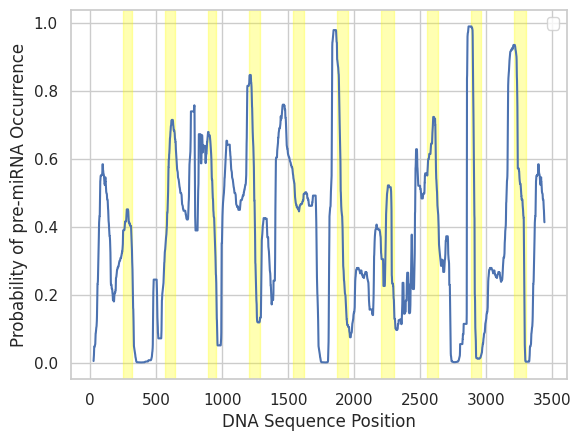

In [47]:
first_screening_instance = Screening(positive_sequences=mirnas_for_screening[:10])
first_screening_instance.mirna_gap = 250
first_screening_instance.generate_sequence_for_screening()
first_screening_instance.get_results_with_word2vec_nn_and_batches(word2vec=miRNA2Vec, model=model_nn, smooth_size=50, smooth_type="median")
first_screening_instance.show_lineplot(column="y_ws_50_median")

In [48]:
iou = first_screening_instance.calculate_iou(probabilities=first_screening_instance.df['y_ws_50_median'])
precision = first_screening_instance.calculate_precision(probabilities=first_screening_instance.df['y_ws_50_median'])
recall = first_screening_instance.calculate_recall(probabilities=first_screening_instance.df['y_ws_50_median'])
print(f"IoU: {iou:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

IoU: 0.2358
Precision: 0.6000
Recall: 0.9000


> For 6839 nucleotides, NN with LSTM model takes 403.2597 seconds



> That would be expressed as 16.9593 nucleotides/s

tiempo de ejecución con 500 nt: 105 seg
tiempo de ejecución con 1000 nt: 106 seg
tiempo de ejecución con 2000 nt: 233 seg
tiempo de ejecución con 5000 nt: 674.62 seg

In [ ]:
mirna_gap_list = [250]
screen_size_list = [50, 75, 100, 150]
smooth_size_list = [25, 50, 75, 100, 150]
smooth_type_list = ["mean", "median", "gaussian" , "triangular"] #, "ema", "savgol", "hamming", "butterworth"
thresholds = np.linspace(0.4, 0.8, 4)  # Generate thresholds between 0 and 1

results_from_tunning = []

screening_instance = Screening(positive_sequences=mirnas_for_screening[:10])

for mirna_gap_item in mirna_gap_list:
    screening_instance.mirna_gap = mirna_gap_item
    screening_instance.generate_sequence_for_screening()
    for screen_size_item in screen_size_list:
        screening_instance.screen_size = screen_size_item
        for threshold in thresholds:
            for smooth_size in smooth_size_list:
                for smooth_type in smooth_type_list:
                    #print(f"Executing {smooth_type} type and {smooth_size} window size")
                    column_name = f"y_ws_{smooth_size}_{smooth_type}"
                    screening_instance.get_results_with_word2vec_nn_and_batches(word2vec=miRNA2Vec, model=model_nn, smooth_size=smooth_size, smooth_type=smooth_type)

                    iou = screening_instance.calculate_iou(probabilities=screening_instance.df[column_name], threshold=threshold)
                    precision = screening_instance.calculate_precision(probabilities=screening_instance.df[column_name], threshold=threshold)
                    recall = screening_instance.calculate_recall(probabilities=screening_instance.df[column_name], threshold=threshold)

                    current_result = {
                        "mirna_gap": mirna_gap_item,
                        "screen_size": screen_size_item,
                        "threshold": threshold,
                        "smooth_size": smooth_size,
                        "smooth_type": smooth_type,
                        "iou": iou,
                        "precision": precision,
                        "recall": recall
                    }

                    print(f"Current Result: {current_result}")

                    results_from_tunning.append(current_result)

# Find the best combination based on IoU, precision, or recall
best_iou = max(results_from_tunning, key=lambda x: x["iou"])
best_precision = max(results_from_tunning, key=lambda x: x["precision"])
best_recall = max(results_from_tunning, key=lambda x: x["recall"])


Generating sequences for screening...
Calculating embeddings for 3502 sequences...
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step
time executed: 0.5846250057220459 seconds
Current Result: {'mirna_gap': 250, 'screen_size': 50, 'threshold': 0.4, 'smooth_size': 25, 'smooth_type': 'mean', 'iou': 0.2315492957746479, 'precision': 0.4, 'recall': 0.9}
Generating sequences for screening...
Calculating embeddings for 3502 sequences...
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step
time executed: 0.572455883026123 seconds
Current Result: {'mirna_gap': 250, 'screen_size': 50, 'threshold': 0.4, 'smooth_size': 25, 'smooth_type': 'median', 'iou': 0.22784810126582278, 'precision': 0.4642857142857143, 'recall': 0.9}
Generating sequences for screening...
Calculating embeddings for 3502 sequences...
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step
time executed: 0.5720410346984863 seconds
Current Result: {'mirna_gap': 250, 'screen_size': 50, 'threshold': 0.4, 'smooth_size': 25, 'smooth_type': 'gaussian', 'iou': 0.2443

In [53]:

# Print the best combinations
print("Best IoU Combination:")
print(f"Mirna_gap: {best_iou['mirna_gap']}, Screen size: {best_iou['screen_size']}, Threshold: {best_iou['threshold']}, Smooth Size: {best_iou['smooth_size']}, Smooth Type: {best_iou['smooth_type']}, IoU: {best_iou['iou']:.4f}")

print("\nBest Precision Combination:")
print(f"Mirna_gap: {best_iou['mirna_gap']}, Screen size: {best_iou['screen_size']}, Threshold: {best_precision['threshold']}, Smooth Size: {best_precision['smooth_size']}, Smooth Type: {best_precision['smooth_type']}, Precision: {best_precision['precision']:.4f}")

print("\nBest Recall Combination:")
print(f"Mirna_gap: {best_iou['mirna_gap']}, Screen size: {best_iou['screen_size']}, Threshold: {best_recall['threshold']}, Smooth Size: {best_recall['smooth_size']}, Smooth Type: {best_recall['smooth_type']}, Recall: {best_recall['recall']:.4f}")



Best IoU Combination:
Mirna_gap: 250, Screen size: 75, Threshold: 0.4, Smooth Size: 75, Smooth Type: median, IoU: 0.2628

Best Precision Combination:
Mirna_gap: 250, Screen size: 75, Threshold: 0.5333333333333333, Smooth Size: 150, Smooth Type: gaussian, Precision: 1.0000

Best Recall Combination:
Mirna_gap: 250, Screen size: 75, Threshold: 0.4, Smooth Size: 25, Smooth Type: mean, Recall: 0.9000


In [52]:
# Convert results to DataFrame
df_results = pd.DataFrame(results_from_tunning)

# Eopncode smooth_type as numerical values
smooth_type_mapping = {smooth: idx for idx, smooth in enumerate(smooth_type_list)}
df_results["smooth_type"] = df_results["smooth_type"].map(smooth_type_mapping)

# Define columns to include in the parallel coordinates plot
columns_to_plot = ["mirna_gap", "screen_size", "threshold", "smooth_size", "smooth_type", "iou", "precision", "recall"]

# Plot Parallel Coordinates Graph
fig = px.parallel_coordinates(
    df_results,
    dimensions=columns_to_plot,
    color="iou",  # Color by IoU for better visualization
    labels={
        "mirna_gap": "miRNA Gap",
        "screen_size": "Screen Size",
        "threshold": "Threshold",
        "smooth_size": "Smooth Size",
        "smooth_type": "Smooth Type",
        "iou": "IoU",
        "precision": "Precision",
        "recall": "Recall"
    },
    color_continuous_scale=px.colors.sequential.Mint
)

# Show the graph
fig.show()

- cambiar paleta de colores, mas oscuro muestra mejor resultado
- probar aumentando el smooth size


### LSTM

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[0.99297214]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[0.99296016]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[0.99299085]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[0.9929742]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[0.99302834]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[0.99303585]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[0.9930274]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[0.99300826]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[0.99294704]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[0.9929652]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[[0.99303347]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[0.9930051]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[[0.993027]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[0.99298686]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[0.9929491]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[[0.9929529]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
[[0.99295557]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[[0.9929356]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[0.99296725]]
1/

/tmp/ipykernel_3876746/1653366215.py:533: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



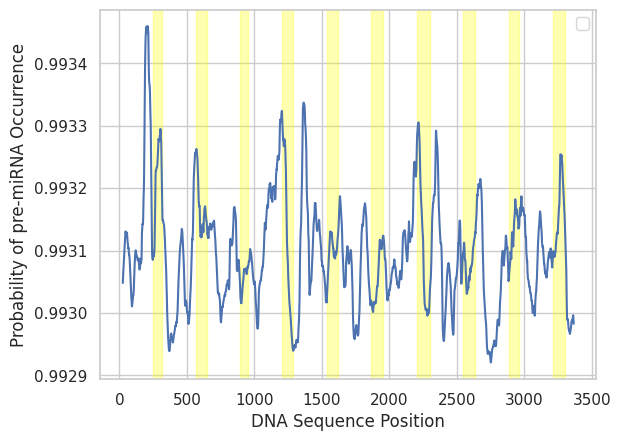

In [83]:
first_screening_instance = Screening(positive_sequences=mirnas_for_screening[:10])
first_screening_instance.mirna_gap = 250
first_screening_instance.screen_size = max_seq_len
first_screening_instance.generate_sequence_for_screening()
first_screening_instance.get_results_with_word2vec_lstm(word2vec=miRNA2Vec, model=model_LSTM, smooth_size=50, smooth_type="mean")
first_screening_instance.show_lineplot(column="y_ws_50_mean")

Tokenizing 3392 sequences...
Padding sequences...
Predicting in batches...
Processing batch 1 of 7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
time executed: 0.6301515102386475 seconds


/tmp/ipykernel_3876746/1911367407.py:486: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



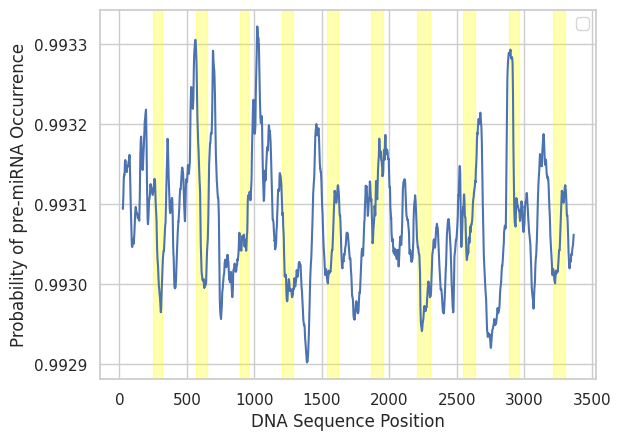

In [80]:
first_screening_instance = Screening(positive_sequences=mirnas_for_screening[:10])
first_screening_instance.mirna_gap = 250
first_screening_instance.screen_size = max_seq_len
first_screening_instance.generate_sequence_for_screening()
first_screening_instance.get_results_with_word2vec_lstm_and_batches(word2vec=miRNA2Vec, model=model_LSTM, smooth_size=50, smooth_type="mean")
first_screening_instance.show_lineplot(column="y_ws_50_mean")

/tmp/ipykernel_3876746/1653366215.py:533: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



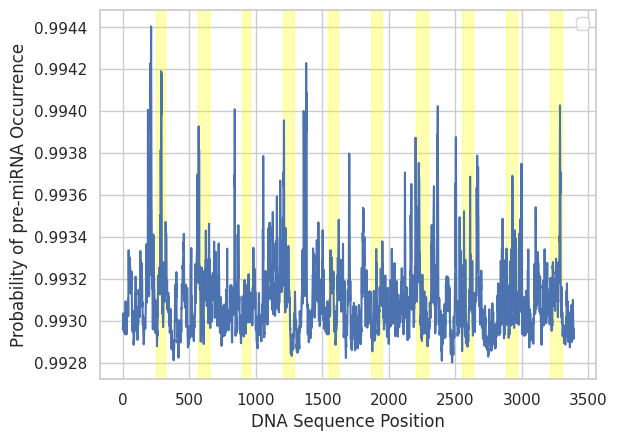

In [85]:
first_screening_instance.show_lineplot(column="y")

### SVC

In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def show_smoothed_lineplot(results, ax, premir_positions=None):
    """
    Plots a smoothed line plot for the given results on the provided axis.

    Parameters:
        results (list or np.ndarray): The screening results to plot.
        ax (matplotlib.axes.Axes): The axis to plot on.
        premir_positions (list of dict): List of regions to highlight with start and end positions.
    """
    # Crear un DataFrame a partir de los datos
    df = pd.DataFrame({'x': range(len(results)), 'y': results})

    # Aplicar promedio móvil con una ventana de tamaño 200
    window_size = 200
    df['y_smoothed'] = df['y'].rolling(window=window_size, center=True).mean()

    # Configuración de la gráfica
    sns.set_theme(style="whitegrid")

    if premir_positions:
        for idx, premir_position in enumerate(premir_positions):
            ax.axvspan(premir_position['start'], premir_position['end'], color='yellow', alpha=0.3)

    sns.lineplot(data=df, x='x', y='y_smoothed', ax=ax, label='')

    # Etiquetas y leyenda
    ax.set_xlabel('DNA Sequence Position')
    ax.set_ylabel('Probability of pre-miRNA Occurrence')


def plot_4_results(sequences_to_screen, get_results_of_screening_with_word2vec_and_svc):
    """
    Plots the screening results for up to 4 sequences from the provided dictionary using subplots.

    Parameters:
        sequences_to_screen (dict): A dictionary where keys are sequence indices and values are DNA sequences.
        get_results_of_screening_with_word2vec_and_svc (function): A function that takes a sequence and returns screening results.
    """
    keys = list(sequences_to_screen.keys())[:4]  # Get up to 4 keys
    num_sequences = len(keys)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2x2 grid
    axes = axes.flatten()  # Flatten into a list of 4 axes

    for i, key in enumerate(keys):
        sequence = sequences_to_screen[key]['seq']

        # Get the screening results for the sequence
        results = get_results_of_screening_with_word2vec_and_svc(sequence)

        # Plot the smoothed lineplot for the current sequence
        show_smoothed_lineplot(results, ax=axes[i], premir_positions=sequences_to_screen[key]['pos'])
        axes[i].set_title(f'distance of {200+key} nt')

    # Remove extra subplots if there are fewer than 4 sequences
    for i in range(num_sequences, 4):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()


sacar metricas de screening:
- se entrenaron 2 modelos, uno sofisticado y otro sencillo. Para screening importa más la rapidez al rendimiento.

> For 12339 nucleotides, SVC model takes 14.7106 seconds



> That would be expressed as 838.783 nucleotides/s

Generating sequences for screening...
Calculating embeddings for 3467 sequences...
time executed: 0.9682660102844238 seconds


/tmp/ipykernel_3876746/1911367407.py:486: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



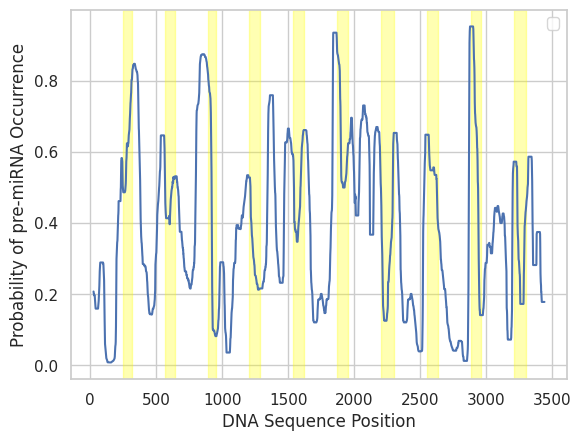

In [62]:
first_screening_instance = Screening(positive_sequences=mirnas_for_screening[:10])
first_screening_instance.mirna_gap = 250
first_screening_instance.generate_sequence_for_screening()
first_screening_instance.get_results_with_word2vec_svc_and_batches(word2vec=miRNA2Vec, svc=svm_model, smooth_size=50, smooth_type="median")
first_screening_instance.show_lineplot(column="y_ws_50_median")

In [63]:
iou = first_screening_instance.calculate_iou(probabilities=first_screening_instance.df['y_ws_50_median'])
precision = first_screening_instance.calculate_precision(probabilities=first_screening_instance.df['y_ws_50_median'])
recall = first_screening_instance.calculate_recall(probabilities=first_screening_instance.df['y_ws_50_median'])
print(f"IoU: {iou:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

IoU: 0.2391
Precision: 0.6667
Recall: 1.0000


In [64]:
mirna_gap_list = [250]
screen_size_list = [50, 75, 100]
smooth_size_list = [50, 75, 100]
smooth_type_list = ["mean", "median", "gaussian", "triangular"] # , "ema", "savgol", "hamming", "butterworth"
thresholds = np.linspace(0.4, 0.7, 5)  # Generate thresholds between 0 and 1

results_from_tunning = []

screening_instance = Screening(positive_sequences=mirnas_for_screening[:10])

for mirna_gap_item in mirna_gap_list:
    screening_instance.mirna_gap = mirna_gap_item
    screening_instance.generate_sequence_for_screening()
    for screen_size_item in screen_size_list:
        screening_instance.screen_size = screen_size_item
        for threshold in thresholds:
            for smooth_size in smooth_size_list:
                for smooth_type in smooth_type_list:
                    #print(f"Executing {smooth_type} type and {smooth_size} window size")
                    column_name = f"y_ws_{smooth_size}_{smooth_type}"
                    screening_instance.get_results_with_word2vec_svc_and_batches(word2vec=miRNA2Vec, svc=svm_model, smooth_size=smooth_size, smooth_type=smooth_type)

                    iou = screening_instance.calculate_iou(probabilities=screening_instance.df[column_name], threshold=threshold)
                    precision = screening_instance.calculate_precision(probabilities=screening_instance.df[column_name], threshold=threshold)
                    recall = screening_instance.calculate_recall(probabilities=screening_instance.df[column_name], threshold=threshold)

                    current_result = {
                        "mirna_gap": mirna_gap_item,
                        "screen_size": screen_size_item,
                        "threshold": threshold,
                        "smooth_size": smooth_size,
                        "smooth_type": smooth_type,
                        "iou": iou,
                        "precision": precision,
                        "recall": recall
                    }

                    print(f"Current Result: {current_result}")

                    results_from_tunning.append(current_result)

# Find the best combination based on IoU, precision, or recall
best_iou = max(results_from_tunning, key=lambda x: x["iou"])
best_precision = max(results_from_tunning, key=lambda x: x["precision"])
best_recall = max(results_from_tunning, key=lambda x: x["recall"])

# Print the best combinations
print("Best IoU Combination:")
print(f"Mirna_gap: {best_iou['mirna_gap']}, Screen size: {best_iou['screen_size']}, Threshold: {best_iou['threshold']}, Smooth Size: {best_iou['smooth_size']}, Smooth Type: {best_iou['smooth_type']}, IoU: {best_iou['iou']:.4f}")

print("\nBest Precision Combination:")
print(f"Mirna_gap: {best_iou['mirna_gap']}, Screen size: {best_iou['screen_size']}, Threshold: {best_precision['threshold']}, Smooth Size: {best_precision['smooth_size']}, Smooth Type: {best_precision['smooth_type']}, Precision: {best_precision['precision']:.4f}")

print("\nBest Recall Combination:")
print(f"Mirna_gap: {best_iou['mirna_gap']}, Screen size: {best_iou['screen_size']}, Threshold: {best_recall['threshold']}, Smooth Size: {best_recall['smooth_size']}, Smooth Type: {best_recall['smooth_type']}, Recall: {best_recall['recall']:.4f}")



Generating sequences for screening...
Calculating embeddings for 3502 sequences...
time executed: 0.6842391490936279 seconds
Current Result: {'mirna_gap': 250, 'screen_size': 50, 'threshold': 0.4, 'smooth_size': 50, 'smooth_type': 'mean', 'iou': 0.2045562411010916, 'precision': 0.5789473684210527, 'recall': 0.8}
Generating sequences for screening...
Calculating embeddings for 3502 sequences...
time executed: 0.6645143032073975 seconds
Current Result: {'mirna_gap': 250, 'screen_size': 50, 'threshold': 0.4, 'smooth_size': 50, 'smooth_type': 'median', 'iou': 0.20250723240115717, 'precision': 0.6111111111111112, 'recall': 0.9}
Generating sequences for screening...
Calculating embeddings for 3502 sequences...
time executed: 0.6627635955810547 seconds
Current Result: {'mirna_gap': 250, 'screen_size': 50, 'threshold': 0.4, 'smooth_size': 50, 'smooth_type': 'gaussian', 'iou': 0.20207743153918792, 'precision': 0.7142857142857143, 'recall': 1.0}
Generating sequences for screening...
Calculating 

In [87]:
# Convert results to DataFrame
df_results = pd.DataFrame(results_from_tunning)

# Encode smooth_type as numerical values
smooth_type_mapping = {smooth: idx for idx, smooth in enumerate(smooth_type_list)}
df_results["smooth_type"] = df_results["smooth_type"].map(smooth_type_mapping)

# Define columns to include in the parallel coordinates plot
columns_to_plot = ["mirna_gap", "screen_size", "threshold", "smooth_size", "smooth_type", "iou", "precision", "recall"]

# Plot Parallel Coordinates Graph
fig = px.parallel_coordinates(
    df_results,
    dimensions=columns_to_plot,
    color="iou",  # Color by IoU for better visualization
    labels={
        "mirna_gap": "miRNA Gap",
        "screen_size": "Screen Size",
        "threshold": "Threshold",
        "smooth_size": "Smooth Size",
        "smooth_type": "Smooth Type",
        "iou": "IoU",
        "precision": "Precision",
        "recall": "Recall"
    },
    color_continuous_scale=px.colors.sequential.Mint
)

# Show the graph
fig.show()

In [ ]:
iou_values = []
for i in range(0, 50, 10):
    screening_instance = Screening(positive_sequences=mirnas_for_screening[i:i+10])
    screening_instance.generate_sequence_for_screening()
    screening_instance.get_results_with_word2vec_and_svc(word2vec=miRNA2Vec, svc=svm_model)
    iou = screening_instance.calculate_iou(screening_instance.df['y_ws_200_mean'], threshold=0.5)
    iou_values.append(iou)

# Compute variance
iou_variance = np.var(iou_values)
iou_mean = np.mean(iou_values)

predicting 0 of 6310
predicting 2000 of 6310
predicting 4000 of 6310
predicting 6000 of 6310
time executed: 17.16321849822998 seconds
predicting 0 of 6299
predicting 2000 of 6299
predicting 4000 of 6299
predicting 6000 of 6299
time executed: 8.8515043258667 seconds
predicting 0 of 6287
predicting 2000 of 6287
predicting 4000 of 6287
predicting 6000 of 6287
time executed: 9.606922149658203 seconds
predicting 0 of 6454
predicting 2000 of 6454
predicting 4000 of 6454
predicting 6000 of 6454
time executed: 15.204957008361816 seconds
predicting 0 of 6424
predicting 2000 of 6424
predicting 4000 of 6424
predicting 6000 of 6424
time executed: 11.76205039024353 seconds


In [ ]:
print(f"Screening IoU: {iou_mean:.4f} ± {iou_variance:.4f}")

Screening IoU: 0.1872 ± 0.0023


### RF

In [ ]:
def get_results_of_screening_with_word2vec_and_rf(sequence_for_screening, screen_size=85):
    results_mirna = []
    start = time.time()
    for idx in range(0, len(sequence_for_screening)-screen_size):
        if (idx % 1000 == 0): print(f"predicting {idx} of {len(sequence_for_screening)}")
        new_sequence = sequence_for_screening[idx:idx+screen_size]
        new_embedding = miRNA2Vec.get_median_embeddings([new_sequence])
        new_prediction = rf_model.predict_proba(new_embedding)
        results_mirna.append(new_prediction[0][1])
    end = time.time()
    print(f"time: {end-start} seconds")
    return results_mirna

predicting 0 of 4839
predicting 1000 of 4839
predicting 2000 of 4839
predicting 3000 of 4839
predicting 4000 of 4839
time: 10.505055904388428 seconds
predicting 0 of 9839
predicting 1000 of 9839
predicting 2000 of 9839
predicting 3000 of 9839
predicting 4000 of 9839
predicting 5000 of 9839
predicting 6000 of 9839
predicting 7000 of 9839
predicting 8000 of 9839
predicting 9000 of 9839
time: 21.188310384750366 seconds
predicting 0 of 14839
predicting 1000 of 14839
predicting 2000 of 14839
predicting 3000 of 14839
predicting 4000 of 14839
predicting 5000 of 14839
predicting 6000 of 14839
predicting 7000 of 14839
predicting 8000 of 14839
predicting 9000 of 14839
predicting 10000 of 14839
predicting 11000 of 14839
predicting 12000 of 14839
predicting 13000 of 14839
predicting 14000 of 14839
time: 31.823708295822144 seconds
predicting 0 of 19839
predicting 1000 of 19839
predicting 2000 of 19839
predicting 3000 of 19839
predicting 4000 of 19839
predicting 5000 of 19839
predicting 6000 of 1983

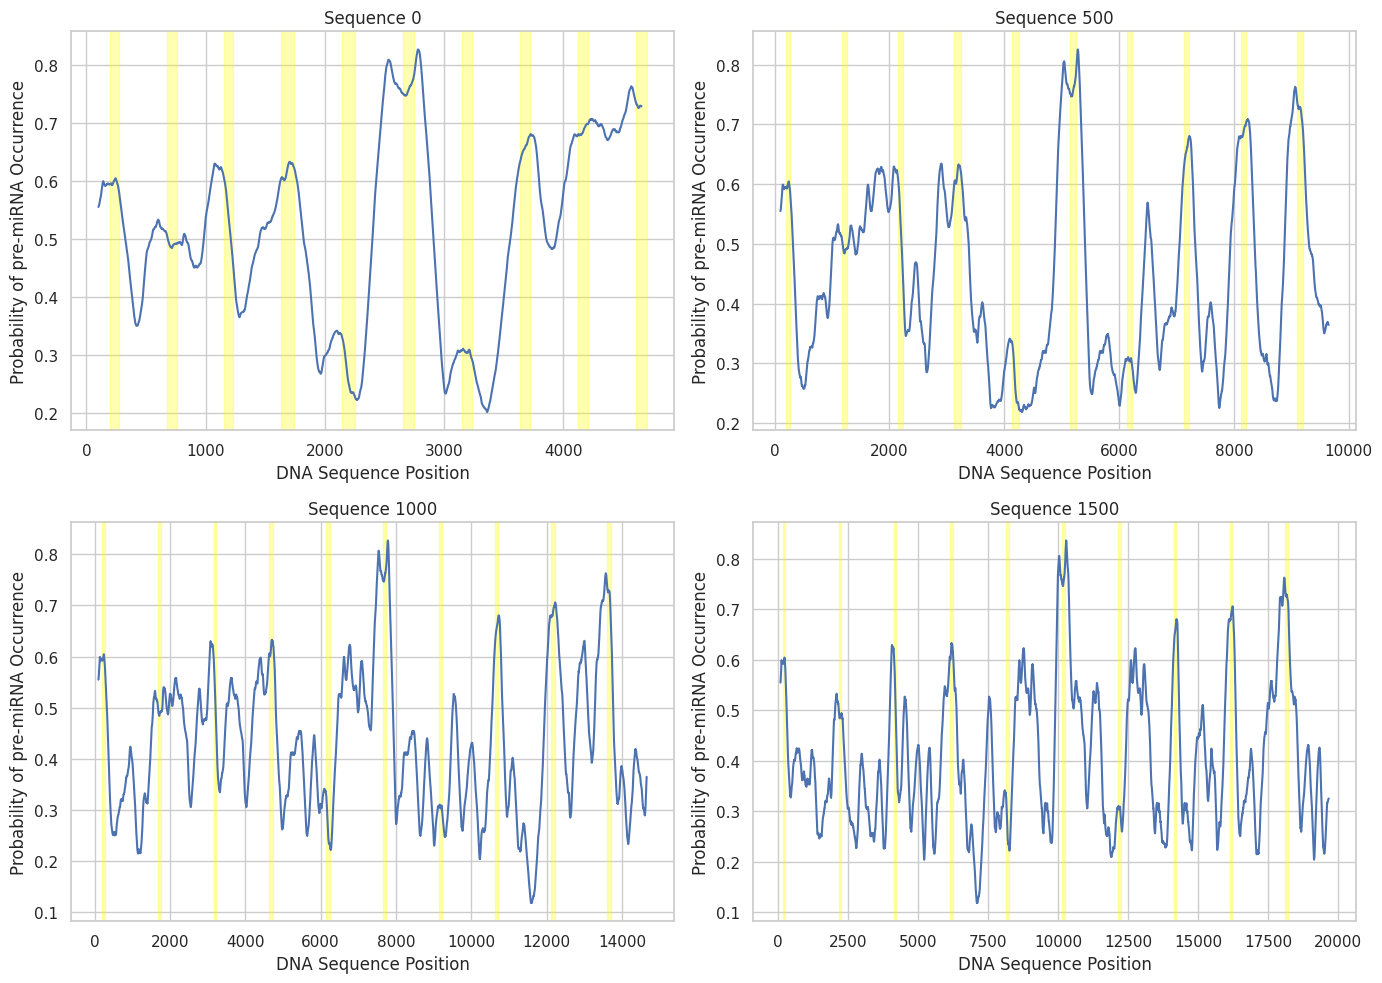

In [ ]:
# Call the function to plot the results for up to 4 sequences
plot_4_results(sequences_to_screen_dict, get_results_of_screening_with_word2vec_and_rf)

# Tuning

### NN

In [ ]:
# Definir el rango de hiperparámetros a probar
param_grid = {
    'neurons': [50, 60],              # Número de neuronas en la capa oculta
    'activation': ['relu', 'tanh'],        # Función de activación
    'optimizer': ['sgd', 'adam'],          # Optimizador
    'batch_size': [2048],                # Tamaño del batch
    'epochs': [300],                     # Número de épocas
    'dropout': [0.7, 0.8],
    'l2_val': [0.001, 0.01]
}


best_score = -np.inf
best_params = None

# Probar cada combinación de hiperparámetros
for params in ParameterGrid(param_grid):
    print(f"Probando con hiperparámetros: {params}")

    # Crear el modelo con los hiperparámetros actuales
    model = create_model(dropout=params['dropout'], neurons=params['neurons'], activation=params['activation'], optimizer=params['optimizer'], l2_val=params['l2_val'])

    # Entrenar el modelo
    model.fit(X_train_mirna2vec, y_train, epochs=params['epochs'], validation_data=(X_val_mirna2vec, y_val), batch_size=params['batch_size'])

    # Predecir y evaluar
    y_pred = (np.array([ele[0] for ele in model.predict(X_test_mirna2vec)]) > 0.5).astype("int32")

    # Evaluar el modelo
    score = f1_score_custom(y_test, y_pred)

    print(f"Score: {score}")

    # Si es mejor que el anterior, guarda los mejores parámetros
    if score > best_score:
        best_score = score
        best_params = params

print(f"Mejores hiperparámetros: {best_params} con un score de {best_score}")


Probando con hiperparámetros: {'activation': 'relu', 'batch_size': 2048, 'dropout': 0.7, 'epochs': 300, 'l2_val': 0.001, 'neurons': 50, 'optimizer': 'sgd'}
Epoch 1/300


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - accuracy: 0.4999 - f1_score_custom: 0.5712 - loss: 1.3601 - val_accuracy: 0.5090 - val_f1_score_custom: 0.5711 - val_loss: 0.7776
Epoch 2/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5124 - f1_score_custom: 0.5710 - loss: 1.2657 - val_accuracy: 0.5115 - val_f1_score_custom: 0.5709 - val_loss: 0.7755
Epoch 3/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5145 - f1_score_custom: 0.5708 - loss: 1.2675 - val_accuracy: 0.5090 - val_f1_score_custom: 0.5707 - val_loss: 0.7734
Epoch 4/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5123 - f1_score_custom: 0.5707 - loss: 1.3073 - val_accuracy: 0.5223 - val_f1_score_custom: 0.5705 - val_loss: 0.7717
Epoch 5/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5116 - f1_score_custom: 0.5705 - loss: 1.2430 - val_accuracy: 0.5283 - val_f1_score_custom: 0.5704 - val_loss: 0.7701
Epoch 6/300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5114 - f1_score_custom: 0.5703 - loss

## LSTM

In [ ]:
# Definir el rango de hiperparámetros a probar
param_grid = {
    'neurons': [16, 32, 64],              # Número de neuronas en la capa oculta
    'activation': ['relu', 'tanh'],        # Función de activación
    'optimizer': ['sgd', 'adam'],          # Optimizador
    'batch_size': [512],                # Tamaño del batch
    'epochs': [300],                     # Número de épocas
    'dropout': [0, 0.7],
    'l2_val': [0.001, 0.01]
}


best_score = -np.inf
best_params = None

# Probar cada combinación de hiperparámetros
for params in ParameterGrid(param_grid):
    print(f"Probando con hiperparámetros: {params}")

    # Crear el modelo con los hiperparámetros actuales
    model = create_model_LSTM(mer_to_index, miRNA2Vec, max_seq_len, dropout=params['dropout'], neurons=params['neurons'], activation=params['activation'], optimizer=params['optimizer'], l2_val=params['l2_val'])

    # Entrenar el modelo
    model.fit(X_train_pad_sequences, y_train, epochs=params['epochs'], verbose=1, validation_data=(X_val_pad_sequences, y_val), batch_size=params['batch_size'])

    # Predecir y evaluar
    y_pred = (np.array([ele[0] for ele in model.predict(X_test_pad_sequences)]) > 0.5).astype("int32")

    # Evaluar el modelo
    score = f1_score(y_test, y_pred)

    print(f"Score: {score}")

    # Si es mejor que el anterior, guarda los mejores parámetros
    if score > best_score:
        best_score = score
        best_params = params

print(f"Mejores hiperparámetros: {best_params} con un score de {best_score}")


NameError: name 'np' is not defined

## miRNA

In [ ]:
# Supón que tienes una función para evaluar el modelo (defínela según tu necesidad).
def evaluate_model():
    tokenized_sequences = miRNA2Vec.tokenize_sequences(X_train)
    # Train the Word2Vec model
    miRNA2Vec.train_word2vec(tokenized_sequences)
    return get_centroid_distance()

# Definir el rango de hiperparámetros a probar
param_grid = {
    'k_mers': [3, 4, 5],
    'vector_size': [128],
    'epochs': [20],
    'skip_gram': [0],
    'min_count': [1, 2],
    'hs': [0, 1],
    'alpha': [0.01, 0.1],
    'min_alpha': [0.001, 0.01],
}

# Proceso de búsqueda de hiperparámetros
best_score = -np.inf
best_params = None

for params in ParameterGrid(param_grid):
    print(f"Probando con hiperparámetros: {params}")
    miRNA2Vec = MiRNA2Vec(
        k_mers=params['k_mers'], 
        vector_size=params['vector_size'], 
        epochs=params['epochs'],
        skip_gram=params['skip_gram'],
        min_count=params['min_count'],
        hs=params['hs'],
        alpha=params['alpha'],
        min_alpha=params['min_alpha'],
        
    )

    # Evalúa el modelo
    score = evaluate_model()

    print(f"Score: {score}")

    # Si es mejor que el anterior, guarda los mejores parámetros
    if score > best_score:
        best_score = score
        best_params = params

print(f"Mejores hiperparámetros: {best_params} con un score de {best_score}")

Probando con hiperparámetros: {'alpha': 0.01, 'epochs': 20, 'hs': 0, 'k_mers': 3, 'min_alpha': 0.001, 'min_count': 1, 'skip_gram': 0, 'vector_size': 128}
Centroid Distance: 1.2059
Score: 1.2059409416651437
Probando con hiperparámetros: {'alpha': 0.01, 'epochs': 20, 'hs': 0, 'k_mers': 3, 'min_alpha': 0.001, 'min_count': 1, 'skip_gram': 1, 'vector_size': 128}
Centroid Distance: 0.1745
Score: 0.17448165280267416
Probando con hiperparámetros: {'alpha': 0.01, 'epochs': 20, 'hs': 0, 'k_mers': 3, 'min_alpha': 0.001, 'min_count': 2, 'skip_gram': 0, 'vector_size': 128}
Centroid Distance: 1.2163
Score: 1.2163412658610524
Probando con hiperparámetros: {'alpha': 0.01, 'epochs': 20, 'hs': 0, 'k_mers': 3, 'min_alpha': 0.001, 'min_count': 2, 'skip_gram': 1, 'vector_size': 128}
Centroid Distance: 0.1745
Score: 0.17451321196021116
Probando con hiperparámetros: {'alpha': 0.01, 'epochs': 20, 'hs': 0, 'k_mers': 3, 'min_alpha': 0.01, 'min_count': 1, 'skip_gram': 0, 'vector_size': 128}
Centroid Distance: 1.

## SVC


In [ ]:
# Definir el rango de hiperparámetros a probar
param_grid = {
    'kernel': ['rbf', 'poly'],
    'class_weight': ['balanced', None],
    'c': np.linspace(0.1, 100, 500)
}

# Proceso de búsqueda de hiperparámetros
best_score = -np.inf
best_params = None

# Get average embeddings for sequences
X_train_mirna2vec = miRNA2Vec.get_median_embeddings(X_train)
X_test_mirna2vec = miRNA2Vec.get_median_embeddings(X_test)

for params in ParameterGrid(param_grid):
    print(f"Probando con hiperparámetros: {params}")
    # Train SVM
    svm_model = SVC(kernel=params['kernel'], class_weight=params['class_weight'], C=params['c'], probability=True)
    svm_model.fit(X_train_mirna2vec, y_train)
    # Predict and evaluate
    y_pred = svm_model.predict(X_test_mirna2vec)
    # Evalúa el modelo
    score = f1_score_sklearn(y_test, y_pred)

    print(f"Score: {score}")

    # Si es mejor que el anterior, guarda los mejores parámetros
    if score > best_score:
        best_score = score
        best_params = params

print(f"Mejores hiperparámetros: {best_params} con un score de {best_score}")

Probando con hiperparámetros: {'c': 0.1, 'class_weight': 'balanced', 'kernel': 'rbf'}
Score: 0.6345679012345679
Probando con hiperparámetros: {'c': 0.1, 'class_weight': 'balanced', 'kernel': 'poly'}
Score: 0.6306532663316583
Probando con hiperparámetros: {'c': 0.1, 'class_weight': None, 'kernel': 'rbf'}
Score: 0.6325
Probando con hiperparámetros: {'c': 0.1, 'class_weight': None, 'kernel': 'poly'}
Score: 0.621656050955414
Probando con hiperparámetros: {'c': 0.30020040080160326, 'class_weight': 'balanced', 'kernel': 'rbf'}
Score: 0.6485148514851485
Probando con hiperparámetros: {'c': 0.30020040080160326, 'class_weight': 'balanced', 'kernel': 'poly'}
Score: 0.6828675577156743
Probando con hiperparámetros: {'c': 0.30020040080160326, 'class_weight': None, 'kernel': 'rbf'}
Score: 0.6425
Probando con hiperparámetros: {'c': 0.30020040080160326, 'class_weight': None, 'kernel': 'poly'}
Score: 0.6707768187422934
Probando con hiperparámetros: {'c': 0.5004008016032064, 'class_weight': 'balanced', '

## NB

In [ ]:
# Definir el rango de hiperparámetros a probar
param_grid = {
    'var_smoothing': np.logspace(0, -9, num=20)
}

# Proceso de búsqueda de hiperparámetros
best_score = -np.inf
best_params = None

# Get embeddings for sequences
X_train_mirna2vec = miRNA2Vec.get_median_embeddings(X_train)
X_test_mirna2vec = miRNA2Vec.get_median_embeddings(X_test)

# Probar cada combinación de hiperparámetros
for params in ParameterGrid(param_grid):
    print(f"Probando con hiperparámetros: {params}")

    # Train Naive Bayes
    nb_model = GaussianNB(var_smoothing=params['var_smoothing'])
    nb_model.fit(X_train_mirna2vec, y_train)

    # Predict and evaluate
    y_pred = nb_model.predict(X_test_mirna2vec)

    # Evalúa el modelo
    score = f1_score_sklearn(y_test, y_pred)

    print(f"Score: {score}")

    # Si es mejor que el anterior, guarda los mejores parámetros
    if score > best_score:
        best_score = score
        best_params = params

print(f"Mejores hiperparámetros: {best_params} con un score de {best_score}")


Probando con hiperparámetros: {'var_smoothing': 1.0}
Score: 0.6585365853658537
Probando con hiperparámetros: {'var_smoothing': 0.3359818286283782}
Score: 0.6626506024096386
Probando con hiperparámetros: {'var_smoothing': 0.11288378916846892}
Score: 0.658753709198813
Probando con hiperparámetros: {'var_smoothing': 0.0379269019073225}
Score: 0.6608187134502924
Probando con hiperparámetros: {'var_smoothing': 0.012742749857031341}
Score: 0.6608187134502924
Probando con hiperparámetros: {'var_smoothing': 0.004281332398719396}
Score: 0.6608187134502924
Probando con hiperparámetros: {'var_smoothing': 0.0014384498882876629}
Score: 0.6608187134502924
Probando con hiperparámetros: {'var_smoothing': 0.0004832930238571757}
Score: 0.6608187134502924
Probando con hiperparámetros: {'var_smoothing': 0.00016237767391887227}
Score: 0.6608187134502924
Probando con hiperparámetros: {'var_smoothing': 5.455594781168526e-05}
Score: 0.6608187134502924
Probando con hiperparámetros: {'var_smoothing': 1.83298071

## RF

In [ ]:
# Definir el rango de hiperparámetros a probar
param_grid = {
    'n_estimators': [10, 50, 100],  # Número de árboles en el bosque
    'max_depth': [None, 5, 10],      # Profundidad máxima del árbol
    'min_samples_split': [2, 8, 16],  # Número mínimo de muestras para dividir un nodo
    'class_weight': ['balanced', None],
    'max_features': ['sqrt', 'log2', None]
}

# Proceso de búsqueda de hiperparámetros
best_score = -np.inf
best_params = None

# Get embeddings for sequences
X_train_mirna2vec = miRNA2Vec.get_median_embeddings(X_train)
X_test_mirna2vec = miRNA2Vec.get_median_embeddings(X_test)

# Probar cada combinación de hiperparámetros
for params in ParameterGrid(param_grid):
    print(f"Probando con hiperparámetros: {params}")

    # Train Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        class_weight=params['class_weight'],
        random_state=42
    )
    rf_model.fit(X_train_mirna2vec, y_train)

    # Predict and evaluate
    y_pred = rf_model.predict(X_test_mirna2vec)

    # Evalúa el modelo
    score = f1_score_sklearn(y_test, y_pred)

    print(f"Score: {score}")

    # Si es mejor que el anterior, guarda los mejores parámetros
    if score > best_score:
        best_score = score
        best_params = params

print(f"Mejores hiperparámetros: {best_params} con un score de {best_score}")


Probando con hiperparámetros: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 10}
Score: 0.670926517571885
Probando con hiperparámetros: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 50}
Score: 0.7289156626506024
Probando con hiperparámetros: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
Score: 0.7277936962750716
Probando con hiperparámetros: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 8, 'n_estimators': 10}
Score: 0.7082152974504249
Probando con hiperparámetros: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 8, 'n_estimators': 50}
Score: 0.7327823691460055
Probando con hiperparámetros: {'class_weight': 'balanced', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 8, 'n_estimators'

# Model 1

In [ ]:
"""
mfe - Minimum Free Energy kcal . mol ** -1
ss  - Secondary Structure
"""

def dot_bracket_to_pairing_matrix(dot_bracket):
    L = len(dot_bracket)
    matrix = np.zeros((L, L), dtype=int)
    stack = []

    for i, char in enumerate(dot_bracket):
        if char == '(':
            stack.append(i)
        elif char == ')':
            if stack:
                j = stack.pop()
                matrix[i, j] = 1
                matrix[j, i] = 1

    return matrix


def one_hot_encode_sequence(sequence):
    mapping = {'A': [1, 0, 0, 0], 'C': [0, 1, 0, 0], 'G': [0, 0, 1, 0], 'U': [0, 0, 0, 1], 'T': [0, 0, 0, 1]}
    one_hot = np.array([mapping[base] for base in sequence])
    return one_hot


def reshape_and_replicate_horizontally(one_hot):
    L, _ = one_hot.shape
    reshaped = one_hot.reshape(L, 1, 4)
    replicated = np.tile(reshaped, (1, L, 1))
    return replicated


def reshape_and_replicate_vertically(one_hot):
    L, _ = one_hot.shape
    reshaped = one_hot.reshape(1, L, 4)
    replicated = np.tile(reshaped, (L, 1, 1))
    return replicated

def pad_matrix_to_fixed_size(matrix, target_shape):
    """
    Pads a 3D matrix with zeros to achieve the target shape.

    Parameters:
        matrix (np.ndarray): Input matrix to be padded.
        target_shape (tuple): Target shape (height, width, depth).

    Returns:
        np.ndarray: Padded matrix with the target shape.
    """
    padded_matrix = np.zeros(target_shape, dtype=matrix.dtype)
    # Copy original matrix into the padded matrix
    original_shape = matrix.shape
    padded_matrix[:original_shape[0], :original_shape[1], :original_shape[2]] = matrix
    return padded_matrix

# seq = "AGACGACAAGGUUGAAUCGCACCCACAGUCUAUGAGUCGGUG"
# fc  = RNA.fold_compound(seq)
# (ss, mfe) = fc.mfe()

# print(f"{seq}\n{ss} ({mfe:6.2f})")


# Example sequence
sequence = "GCCCUUGGCA"
fc  = RNA.fold_compound(sequence)
(ss, mfe) = fc.mfe()
print(ss)

""" INPUT REPRESENTATION """

# One-hot encode the sequence
one_hot = one_hot_encode_sequence(sequence)

# Convert pairing matrix to L × L × 1
pairing_matrix_expanded = np.expand_dims(dot_bracket_to_pairing_matrix(ss), axis=2)



concatenated_matrix = np.concatenate(
    (pairing_matrix_expanded,
     reshape_and_replicate_horizontally(one_hot),
     reshape_and_replicate_vertically(one_hot)), axis=2)


# Pad the matrix to the desired shape of 400 × 400 × 9
target_shape = (400, 400, 9)
padded_matrix = pad_matrix_to_fixed_size(concatenated_matrix, target_shape)

# Verify the shape of the padded matrix
print(f"Padded matrix shape: {padded_matrix.shape}")

(((...))).
Padded matrix shape: (400, 400, 9)


In [ ]:
def sum_pooling(inputs):
    return tf.nn.pool(inputs, window_shape=[2, 2], pooling_type='AVG', strides=[2, 2], padding='VALID') * 4

def build_model(input_shape):
    model = models.Sequential()

    # Input layer
    model.add(layers.InputLayer(input_shape=input_shape))

    # Conv2D, ReLU, 2×2 sum-pooling
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.Lambda(sum_pooling))

    # Conv2D, ReLU, 2×2 max-pooling
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Conv2D, ReLU
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))

    # Downscaling to 4×4
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Reshape((1, 1, 128)))
    model.add(layers.UpSampling2D(size=(4, 4)))

    # Fully connected layer, sigmoid, output 256×1
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='sigmoid'))

    # Fully connected layer, output 2×1
    model.add(layers.Dense(2))

    # Softmax for classification
    model.add(layers.Softmax())

    return model

# Example input shape: (L, L, 9)
L = 400  # You can change L to your specific value
input_shape = (L, L, 9)
model_1 = build_model(input_shape)

model_1.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 400, 400, 32)        │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 200, 200, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 200, 200, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 100, 100, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Softmax)                    │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 620,034 (2.37 MB)

 Trainable params: 620,034 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train_model_1 = []
X_test_model_1 = []
y_train_model_1 = []
y_test_model_1 = []

target_shape = (400, 400, 9)

for idx, sequence in enumerate(X_train[:128]):
  sequence = convert_DNA_sequence_to_RNA(sequence)
  #if len(sequence) != 84:
  #  continue
  fc  = RNA.fold_compound(sequence)
  (ss, mfe) = fc.mfe()

  """ INPUT REPRESENTATION """

  # One-hot encode the sequence
  one_hot = one_hot_encode_sequence(sequence)

  # Convert pairing matrix to L × L × 1
  pairing_matrix_expanded = np.expand_dims(dot_bracket_to_pairing_matrix(ss), axis=2)

  concatenated_matrix = np.concatenate(
      (pairing_matrix_expanded,
      reshape_and_replicate_horizontally(one_hot),
      reshape_and_replicate_vertically(one_hot)), axis=2)

  padded_matrix = pad_matrix_to_fixed_size(concatenated_matrix, target_shape)

  X_train_model_1.append(padded_matrix)
  y_train_model_1.append(y_train[idx])

for idx, sequence in enumerate(X_test[:128]):
  sequence = convert_DNA_sequence_to_RNA(sequence)
  #if len(sequence) != 84:
  #  continue
  fc  = RNA.fold_compound(sequence)
  (ss, mfe) = fc.mfe()

  """ INPUT REPRESENTATION """

  # One-hot encode the sequence
  one_hot = one_hot_encode_sequence(sequence)

  # Convert pairing matrix to L × L × 1
  pairing_matrix_expanded = np.expand_dims(dot_bracket_to_pairing_matrix(ss), axis=2)

  concatenated_matrix = np.concatenate(
      (pairing_matrix_expanded,
      reshape_and_replicate_horizontally(one_hot),
      reshape_and_replicate_vertically(one_hot)), axis=2)

  padded_matrix = pad_matrix_to_fixed_size(concatenated_matrix, target_shape)

  X_test_model_1.append(padded_matrix)
  y_test_model_1.append(y_test[idx])

In [ ]:
len(X_train_model_1)

128

In [ ]:
# Compile the model
model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
# Train the model
history_model_1 = model_1.fit(np.array(X_train_model_1[:128]), np.array(y_train_model_1[:128]),
                    epochs=100,
                    batch_size=128,
                    validation_split=0.1,
                    verbose=1)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step - accuracy: 1.0000 - loss: 0.0117 - val_accuracy: 0.4615 - val_loss: 4.4664
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 37s 37s/step - accuracy: 0.8435 - loss: 0.6769 - val_accuracy: 0.6154 - val_loss: 2.2441
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9826 - loss: 0.0369 - val_accuracy: 0.8462 - val_loss: 0.5237
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8783 - loss: 0.2409 - val_accuracy: 0.6923 - val_loss: 0.6080
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.9478 - loss: 0.1080 - val_accuracy: 0.6154 - val_loss: 1.0793
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0259 - val_accuracy: 0.6154 - val_loss: 1.6175
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0238 - val_accuracy: 0.6154 - val_loss: 2.0007
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9739 - loss: 0.0541 - val_accuracy: 0.6154 - val_loss: 2.1846
Epoc

Text(0.5, 1.0, 'Loss Curve')

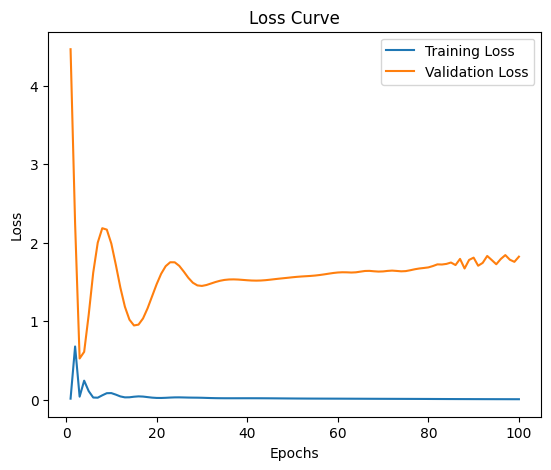

In [ ]:
loss = history_model_1.history['loss']
val_loss = history_model_1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(14, 5))

# Gráfico de loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

Text(0.5, 1.0, 'accuracy Curve')

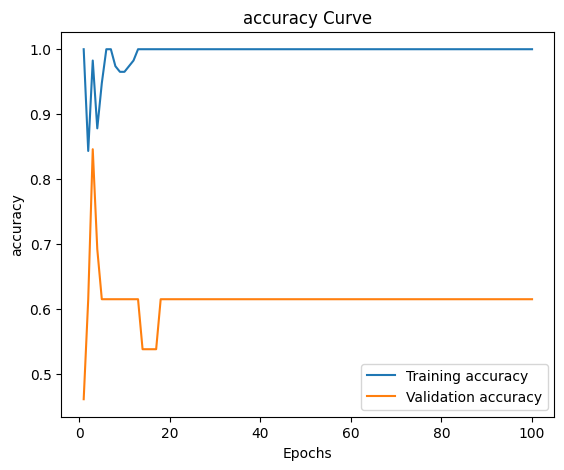

In [ ]:
loss = history_model_1.history['accuracy']
val_loss = history_model_1.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(14, 5))

# Gráfico de loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training accuracy')
plt.plot(epochs, val_loss, label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.title('accuracy Curve')

In [ ]:
# Evaluate the model
test_loss, test_acc = model_1.evaluate(np.array(X_test_model_1[:128]), np.array(y_test_model_1[:128]))
print(f'Test accuracy: {test_acc:.2f}')


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 0.8427 - loss: 0.7521
Test accuracy: 0.85


In [ ]:
y_pred_model_1 = model_1.predict(np.array(X_test_model_1[:128]))
y_pred_model_1 = np.argmax(y_pred_model_1, axis=1)
print("Confusion Matrix:")
print(confusion_matrix(np.array(y_test_model_1[:128]), y_pred_model_1))
print("\nClassification Report:")
print(classification_report(np.array(y_test_model_1[:128]), y_pred_model_1))

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step
Confusion Matrix:
[[47  5]
 [14 62]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.90      0.83        52
         1.0       0.93      0.82      0.87        76

    accuracy                           0.85       128
   macro avg       0.85      0.86      0.85       128
weighted avg       0.86      0.85      0.85       128



## Test Screening

In [ ]:
first_screening_instance = Screening(positive_sequences=mirnas_for_screening[:10])
first_screening_instance.mirna_gap = 250
first_screening_instance.generate_sequence_for_screening()
screen_size = 85
results_model_1 = []
start = time.time()
for idx in range(0, len(first_screening_instance.sequence_for_screening)-screen_size):
    print(f"predicting {idx} of {len(first_screening_instance.sequence_for_screening)}")
    new_sequence = first_screening_instance.sequence_for_screening[idx:idx+screen_size]
    new_sequence = convert_DNA_sequence_to_RNA(new_sequence)

    fc  = RNA.fold_compound(new_sequence)
    (ss, mfe) = fc.mfe()

    """ INPUT REPRESENTATION """

    # One-hot encode the sequence
    one_hot = one_hot_encode_sequence(new_sequence)

    # Convert pairing matrix to L × L × 1
    pairing_matrix_expanded = np.expand_dims(dot_bracket_to_pairing_matrix(ss), axis=2)

    concatenated_matrix = np.concatenate(
        (pairing_matrix_expanded,
        reshape_and_replicate_horizontally(one_hot),
        reshape_and_replicate_vertically(one_hot)), axis=2)

    padded_matrix = pad_matrix_to_fixed_size(concatenated_matrix, target_shape)

    new_prediction = model_1.predict(np.expand_dims(padded_matrix, axis=0))
    results_model_1.append(new_prediction[0][1])
end = time.time()
print(f"time: {end-start} seconds")


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
predicting 1034 of 3618
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
predicting 1035 of 3618
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
predicting 1036 of 3618
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
predicting 1037 of 3618
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
predicting 1038 of 3618
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
predicting 1039 of 3618
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
predicting 1040 of 3618
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
predicting 1041 of 3618
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
predicting 1042 of 3618
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
predicting 1043 of 3618
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
predicting 1044 of 3618
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
predicting 1045 of 3618
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
predicting 1046 of 3618
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
predicting 1047 of 3618
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
predicting 1048 of 3618
1/1 ━━━━━━━━━━━━━━━

   x         y
0  0  0.999999
1  1  0.999978
2  2  0.999994
3  3  0.999999
4  4  0.999997


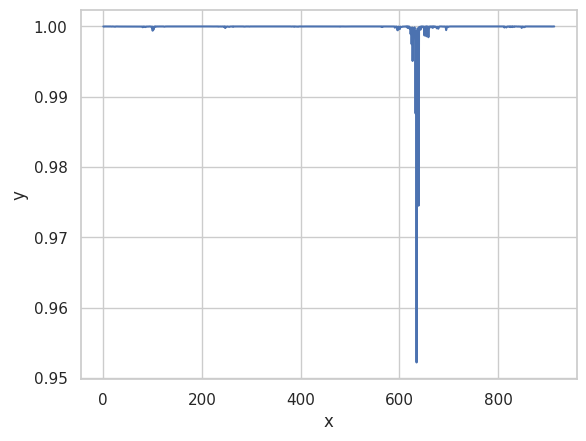

In [ ]:
# Create a DataFrame
df = pd.DataFrame({'x': range(len(results_model_1)), 'y': results_model_1})
print(df.head())
# Create a relplot
sns.set_theme(style="whitegrid")
sns.lineplot(data=df, x='x', y='y')

# Show the plot
plt.show()

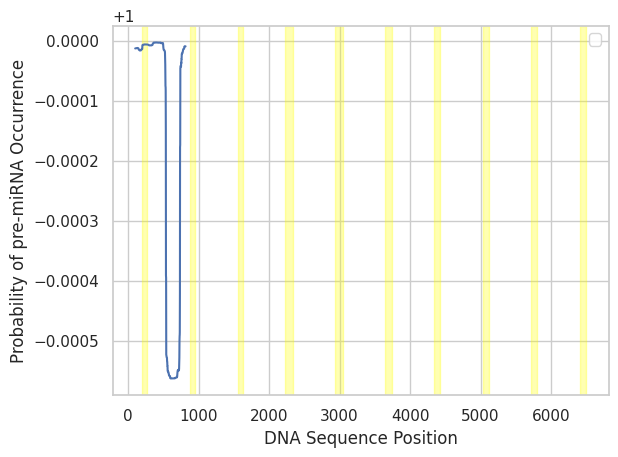

In [ ]:
# Crear un DataFrame a partir de los datos
df = pd.DataFrame({'x': range(len(results_model_1)), 'y': results_model_1})

# Aplicar promedio móvil con una ventana de tamaño 90
window_size = 200
df['y_smoothed'] = df['y'].rolling(window=window_size, center=True).mean()

# Configuración de la gráfica
sns.set_theme(style="whitegrid")
for idx, premir_position in enumerate(premir_positions):
    plt.axvspan(premir_position['start'], premir_position['end'], color='yellow', alpha=0.3, label=f'')
#plt.axvspan(50, 150, color='yellow', alpha=0.3, label='pre-miRNA Presence')
sns.lineplot(data=df, x='x', y='y_smoothed', label='')

# Etiquetas y leyenda
plt.xlabel('DNA Sequence Position')
plt.ylabel('Probability of pre-miRNA Occurrence')
plt.legend()
# plt.title('Screening over 5000 nucleotides on chromosome 1 - Homo sapiens')

# Mostrar la gráfica
plt.show()

# Model 2

In [ ]:
max_seq_len = max(len(seq) for seq in positive_sequences)
max_seq_len = 168
X_train_model_2 = preprocess_dna_sequences(X_train, max_seq_len)
X_test_model_2 = preprocess_dna_sequences(X_test, max_seq_len)
X_train_model_2.shape

(3823, 168, 4)

In [ ]:
!pip install tensorflow
import tensorflow as tf
from keras.layers import Input, Reshape, TimeDistributed, Conv2D, Flatten, LSTM, Dense, Dropout
from keras.models import Model
from tensorflow.keras.optimizers import Adam
def create_cnn_lstm_model(input_length=164, num_filters=128, kernel_height=6, kernel_width=4,
                          lstm_units=100, dense_units=64, dropout_rate=0.5):
    """
    Creates a CNN-LSTM model for miRNA classification, following the described architecture.

    Parameters:
    - input_length: Length of each padded miRNA sequence.
    - num_filters: Number of filters in each convolutional layer.
    - kernel_height: Height of the convolutional kernel.
    - kernel_width: Width of the convolutional kernel.
    - lstm_units: Number of units in the LSTM layer.
    - dense_units: Number of units in the dense layer.
    - dropout_rate: Dropout rate for regularization.

    Returns:
    - model: Compiled CNN-LSTM model.
    """
    # Calculate time steps
    time_steps = input_length // kernel_height

    # Input layer: One-hot encoded padded sequences (batch_size, input_length, 4)
    input_layer = Input(shape=(input_length, 4))  # Shape: (164, 4)

    # Reshape input for time-distributed CNN layers
    reshaped_input = Reshape((time_steps, kernel_height, 4, 1))(input_layer)  # Shape: (batch_size, time_steps, 6, 4, 1)

    # TimeDistributed Conv2D Layers
    conv1 = TimeDistributed(Conv2D(filters=num_filters, kernel_size=(kernel_height, kernel_width), activation='relu', padding='same'))(reshaped_input)
    conv2 = TimeDistributed(Conv2D(filters=num_filters, kernel_size=(kernel_height, kernel_width), activation='relu', padding='same'))(conv1)
    conv3 = TimeDistributed(Conv2D(filters=num_filters, kernel_size=(kernel_height, kernel_width), activation='relu', padding='same'))(conv2)

    # Flatten each time step's output
    flattened_features = TimeDistributed(Flatten())(conv3)

    # LSTM Layer for sequential processing
    lstm_layer = LSTM(units=lstm_units, return_sequences=False, dropout=dropout_rate)(flattened_features)

    # Fully connected dense layer
    dense_layer = Dense(units=dense_units, activation='relu')(lstm_layer)

    # Dropout layer
    dropout_layer = Dropout(rate=dropout_rate)(dense_layer)

    # Output layer for binary classification
    output_layer = Dense(2, activation='softmax')(dropout_layer)

    # Create and compile the model
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
# Create the model
model_2 = create_cnn_lstm_model(input_length=168)

# Summary of the model
model_2.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 168, 4)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_4 (Reshape)                  │ (None, 28, 6, 4, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_10                  │ (None, 28, 6, 4, 128)       │           3,200 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_11                  │ (None, 28, 6, 4, 128)       │         393,344 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_12                  │ (None, 28, 6, 4, 128)       │         393,344 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_13                  │ (None, 28, 3072)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 100)                 │       1,269,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,065,682 (7.88 MB)

 Trainable params: 2,065,682 (7.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Convert y_train to one-hot encoding
from tensorflow.keras.utils import to_categorical
y_train_onehot = to_categorical(y_train, num_classes=2)  # Assuming 2 classes: 0 and 1
# Train the Model
history_model_2 = model_2.fit(X_train_model_2, y_train_onehot, batch_size=128, epochs=30, validation_split=0.1, verbose=1)

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 35s 339ms/step - accuracy: 0.5201 - loss: 0.6913 - val_accuracy: 0.6606 - val_loss: 0.6283
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 210ms/step - accuracy: 0.6416 - loss: 0.6422 - val_accuracy: 0.7023 - val_loss: 0.6052
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step - accuracy: 0.7209 - loss: 0.5658 - val_accuracy: 0.8590 - val_loss: 0.3754
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - accuracy: 0.8748 - loss: 0.3365 - val_accuracy: 0.9661 - val_loss: 0.1213
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 225ms/step - accuracy: 0.9655 - loss: 0.1329 - val_accuracy: 0.9843 - val_loss: 0.0717
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 222ms/step - accuracy: 0.9815 - loss: 0.0866 - val_accuracy: 0.9843 - val_loss: 0.0746
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step - accuracy: 0.9808 - loss: 0.0902 - val_accuracy: 0.9843 - val_loss: 0.0669
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 214ms/step - accuracy: 0.9847 - loss: 0.0682 - val_accurac

Text(0.5, 1.0, 'Loss Curve')

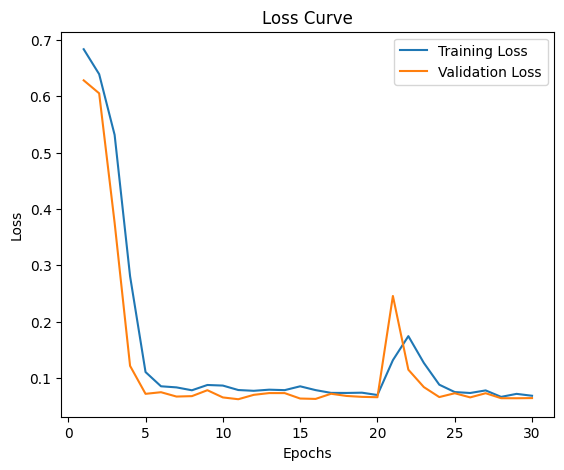

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(14, 5))

# Gráfico de loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

Text(0.5, 1.0, 'Accuracy Curve')

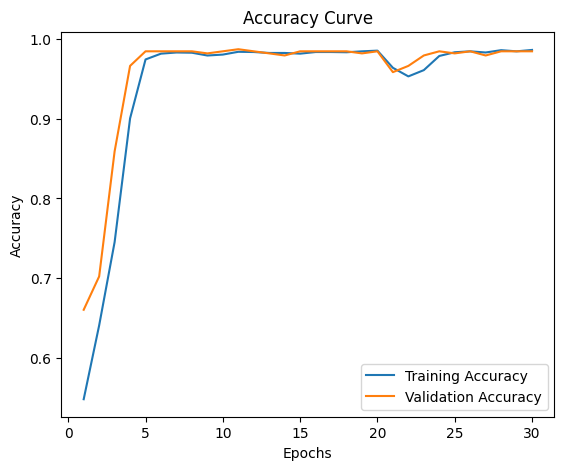

In [ ]:
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(14, 5))

# Gráfico de loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training Accuracy')
plt.plot(epochs, val_loss, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

In [ ]:
# Convert y_train to one-hot encoding
y_test_onehot = to_categorical(y_test, num_classes=2)  # Assuming 2 classes: 0 and 1

y_pred = (np.array([ele[1] for ele in model_2.predict(X_test_model_2)]) > 0.5).astype("int32")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Confusion Matrix:
[[399   2]
 [ 15 403]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       401
         1.0       1.00      0.96      0.98       418

    accuracy                           0.98       819
   macro avg       0.98      0.98      0.98       819
weighted avg       0.98      0.98      0.98       819



Predicting in batches...
Processing batch 1 of 14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
Processing batch 11 of 14
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
time executed: 3.376011848449707 seconds


<ipython-input-66-cb33e07ba867>:495: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


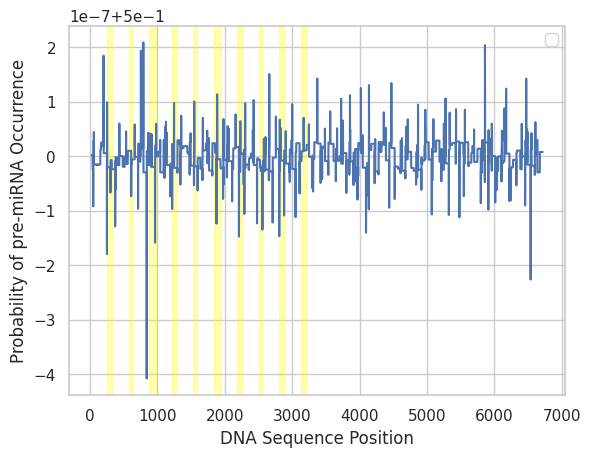

In [ ]:
first_screening_instance = Screening(positive_sequences=mirnas_for_screening[:10])
first_screening_instance.mirna_gap = 250
first_screening_instance.generate_sequence_for_screening()
first_screening_instance.get_results_with_word2vec_and_model_2(word2vec=miRNA2Vec, model=model_2, smooth_size=50, smooth_type="median")
first_screening_instance.show_lineplot(column="y_ws_50_median")